<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#RandomForestRegression" data-toc-modified-id="RandomForestRegression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RandomForestRegression</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Загрузка и подготовка данных

In [1]:
# 1. Библиотеки для работы с данными
import pandas as pd                            # Библиотека для манипуляции и анализа данных
import numpy as np                             # Библиотека для численных вычислений

# 2. Библиотеки для визуализации
import matplotlib.pyplot as plt                # Библиотека для создания статических, анимированных и интерактивных визуализаций
import seaborn as sns                          # Библиотека для визуализации данных на основе Matplotlib

# 3. Библиотека для анализа временных рядов
from statsmodels.tsa.seasonal import seasonal_decompose     # Библиотека для разложения временных рядов

# 4. Библиотеки для построения и оценки моделей
from sklearn.model_selection import train_test_split        # Функция для разделения данных на обучающую и тестовую выборки
from sklearn.metrics import mean_squared_error             # Функция для вычисления среднеквадратичной ошибки
from sklearn.metrics import make_scorer        # Функции для создания пользовательских метрик оценки
from statsmodels.tsa.stattools import adfuller # тест Дики-Фуллера

# 5. Библиотеки для построения и оценки моделей
from lightgbm import LGBMRegressor              # Градиентный бустинг с использованием алгоритмов на основе деревьев
from sklearn.ensemble import RandomForestRegressor       # Ансамблевый метод, который строит несколько деревьев решений
from catboost import CatBoostRegressor          # Библиотека для градиентного бустинга с использованием категориальных признаков
from sklearn.dummy import DummyRegressor        # Базовая модель, которая делает прогнозы с помощью простых правил
from sklearn.linear_model import LinearRegression        # Линейная регрессионная модель
from sklearn.preprocessing import StandardScaler

# 6. Библиотеки для построения и оценки моделей
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit    # Функции для настройки гиперпараметров, временного перекрёстного контроля и оценки кросс-валидации

# 7. Настройки
import time
import warnings
warnings.simplefilter('ignore')  # Игнорирование предупреждений без вывода подробностей
warnings.filterwarnings("ignore")  # Игнорирование предупреждений

# 8. Константы
random_state = 123456  # Задание случайного состояния для воспроизводимости результатов

# 9. Сбросим ограничение на количество выводимых столбцов и строк
pd.set_option('display.max_rows', None)     # Отображение всех строк
pd.set_option('display.max_columns', None)  # Отображение всех столбцов
pd.set_option('display.float_format','{:,.2f}'.format)  # Форматирование вывода чисел с плавающей запятой

In [7]:
# Выводим информацию о версиях установленных библиотек
!pip show pandas seaborn numpy matplotlib seaborn

Name: pandas
Version: 1.2.4
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: None
Author-email: None
License: BSD
Location: /opt/conda/lib/python3.9/site-packages
Requires: python-dateutil, pytz, numpy
Required-by: statsmodels, seaborn, catboost
---
Name: seaborn
Version: 0.11.1
Summary: seaborn: statistical data visualization
Home-page: https://seaborn.pydata.org
Author: Michael Waskom
Author-email: mwaskom@nyu.edu
License: BSD (3-clause)
Location: /opt/conda/lib/python3.9/site-packages
Requires: scipy, numpy, matplotlib, pandas
Required-by: 
---
Name: numpy
Version: 1.21.1
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: None
License: BSD
Location: /opt/conda/lib/python3.9/site-packages
Requires: 
Required-by: xgboost, transformers, thinc, tensorflow-cpu, tensorboard, statsmodels, spacy, seaborn, scipy,

**Чтение данных из CSV-файла и предварительный просмотр**

In [8]:
# Попытаемся прочитать CSV-файл из локального пути '/datasets/taxi.csv'
try:
    df_taxi = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
    
# Если не удалось прочитать файл локально, то выполняем код в блоке except
except:
    # Пробуем прочитать CSV-файл из удаленного источника по URL 'https://code.s3.yandex.net/datasets/taxi.csv'
    df_taxi = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', parse_dates=[0], index_col=[0])

# В данном случае, если файл успешно загружен, данные будут храниться в переменной 'data'
# Если первая попытка чтения из локального пути завершится успешно, блок 'except' не будет выполнен.

In [9]:
# Вывод первых нескольких строк DataFrame для предварительного просмотра данных.
df_taxi.head()

num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32

**Сортировка индекса DataFrame и вывод информации**

In [11]:
df_taxi.sort_index(inplace=True)  # Сортировка индекса DataFrame по возрастанию
df_taxi.info()                   # Вывод информации о DataFrame, включая информацию о столбцах и типах данных

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


**Изменим частоту временного ряда с интервала 10 минут на интервал 1 час путем ресемплирования.**

**Ресемплирование данных с интервалом 1 час**

In [12]:
df_taxi_1h = df_taxi.resample('1H').sum()
# Ресемплирование данных с использованием метода .resample() и аргумента '1H', который указывает на интервал в 1 час.
# Метод .sum() применяется для суммирования значений в каждом интервале.

df_taxi_1h.head()
# Вывод первых нескольких строк ресемплированного DataFrame для предварительного просмотра данных.

num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43

**Проверка монотонности индекса ресемплированного DataFrame**

In [13]:
df_taxi_1h.index.is_monotonic
# Проверка монотонности индекса ресемплированного DataFrame с использованием атрибута .index.is_monotonic.
# Возвращает значение True, если индекс является монотонно возрастающим или монотонно убывающим, и False в противном случае.

True

In [14]:
# Проверка, является ли индекс DataFrame монотонно возрастающим
df_taxi_1h.index.is_monotonic_increasing

True

**Визуализация ресемплированных данных временного ряда**

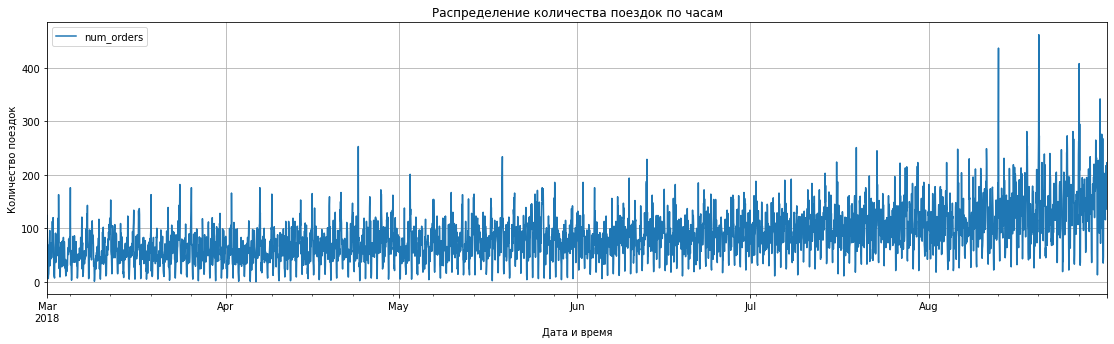

In [15]:
df_taxi_1h.plot(figsize=(19, 5), grid=True)
# Визуализация ресемплированных данных временного ряда с использованием метода .plot().
# Параметр figsize=(19,5) указывает на размеры графика (ширина, высота) в дюймах.
# Параметр grid=True включает отображение сетки на графике.

plt.xlabel('Дата и время')  # Подпись для оси x
plt.ylabel('Количество поездок')  # Подпись для оси y
plt.title('Распределение количества поездок по часам')  # Заголовок графика
plt.show()  # Отображение графика

**Вывод**

- Данные успешно загружены и не содержат пропусков.
- Интервал временного ряда был изменен на 1 час.
- Известно, что период анализа составляет с 1 марта 2018 года по 31 августа 2018 года.

## Анализ

Воспользуемся функцией seasonal_decompose() для анализа тренда и сезонности данных. Эта функция разделяет временной ряд на три компоненты: тренд, сезонность и остаток.

**Анализ тренда и сезонности временного ряда с помощью seasonal_decompose()**

In [16]:
df_decomposed = seasonal_decompose(df_taxi_1h)
# Применение функции seasonal_decompose() для анализа тренда и сезонности временного ряда.
# Результат разложения сохраняется в переменной decomposed.

In [17]:
# Вывод первых нескольких строк столбца 'resid'
df_decomposed.resid.head()

datetime
2018-03-01 00:00:00   NaN
2018-03-01 01:00:00   NaN
2018-03-01 02:00:00   NaN
2018-03-01 03:00:00   NaN
2018-03-01 04:00:00   NaN
Freq: H, Name: resid, dtype: float64

**Визуализация тренда, сезонности и остатков временного ряда**

**Функция для визуализации данных с различными временными интервалами**

In [18]:
def plot_data_ranges(data, title, data_2=None, title_2=None):
    figsize = (19, 6)  # Установка размера графика
    
    date_ranges = [('За весь срок', None, None),
                   ('За месяц', '2018-08', '2018-08'),
                   ('За неделю', '2018-08-25', '2018-08-31'),
                   ('За день', '2018-08-31', '2018-08-31')
                  ]
    
    for range_name, start_date, end_date in date_ranges:
        print(f'График {range_name}')  # Вывод названия интервала
        
        sns.set_style('darkgrid')  # Установка стиля сетки для графика
        plt.figure(figsize=figsize)  # Создание новой фигуры с указанным размером
        
        # Выбор среза данных в зависимости от указанных дат интервала
        data_slice = data[start_date:end_date] if start_date and end_date else data
        
        # Визуализация данных на графике
        data_slice.plot(ax=plt.gca(), figsize=figsize)
        
        if data_2 is not None:
            # Выбор среза второго набора данных в зависимости от указанных дат интервала
            data_2_slice = data_2[start_date:end_date] if start_date and end_date else data_2
            
            # Визуализация второго набора данных на графике
            data_2_slice.plot(ax=plt.gca(), figsize=figsize)
            plt.legend(['Количество заказов', title_2])  # Добавление легенды для данных и второго набора данных
        else:
            plt.legend(['Количество заказов'])  # Добавление легенды только для данных
        
        plt.title(title, y=1.05)  # Задание заголовка для графика
        plt.xlabel('Дата')  # Задание подписи для оси x
        plt.ylabel('Количество')  # Задание подписи для оси y
        plt.tight_layout()  # Улучшение компактности расположения графика
        plt.show()  # Отображение графика

**Генерация графика распределения количества заказов в час**

График За весь срок


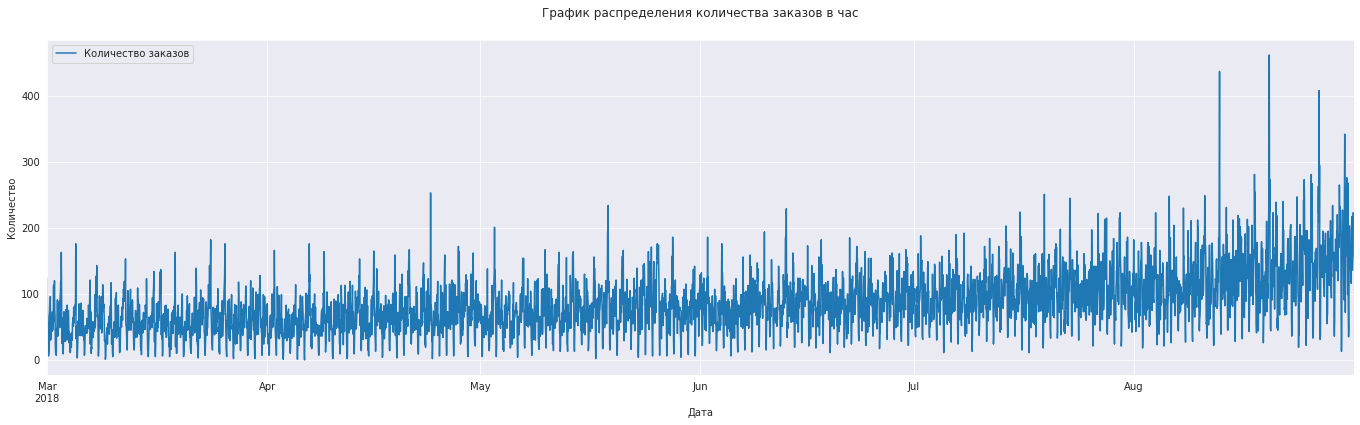

График За месяц


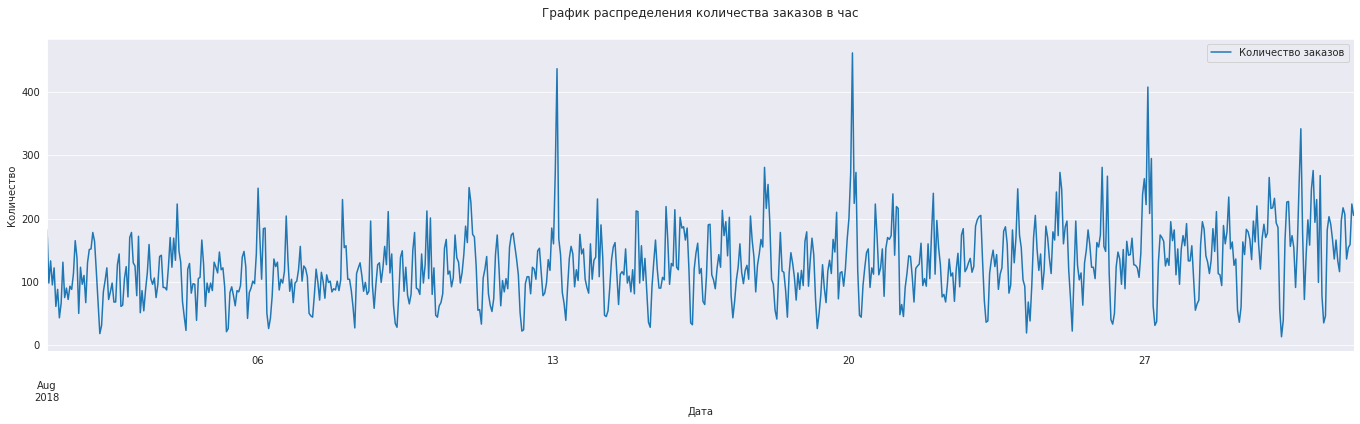

График За неделю


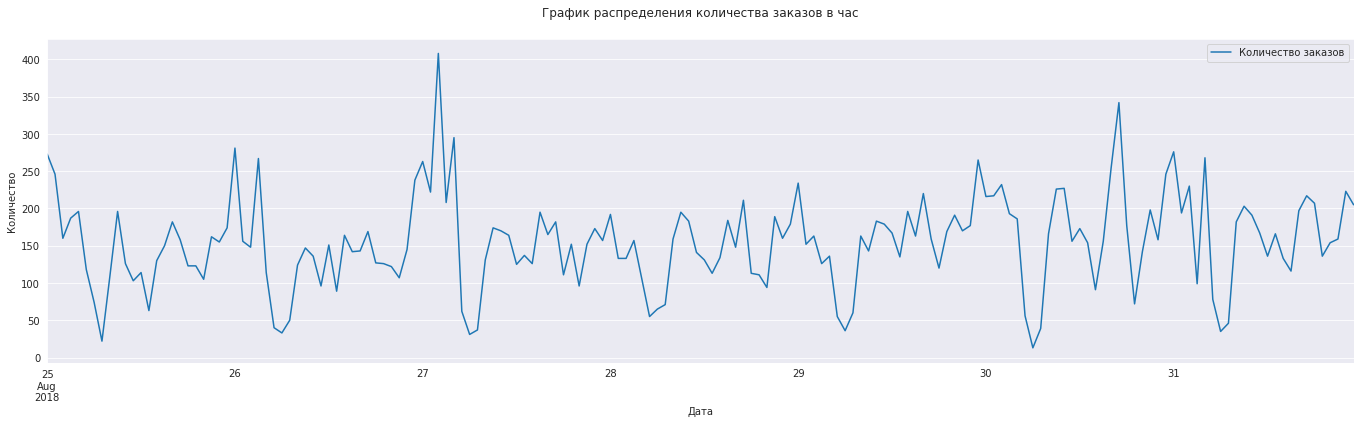

График За день


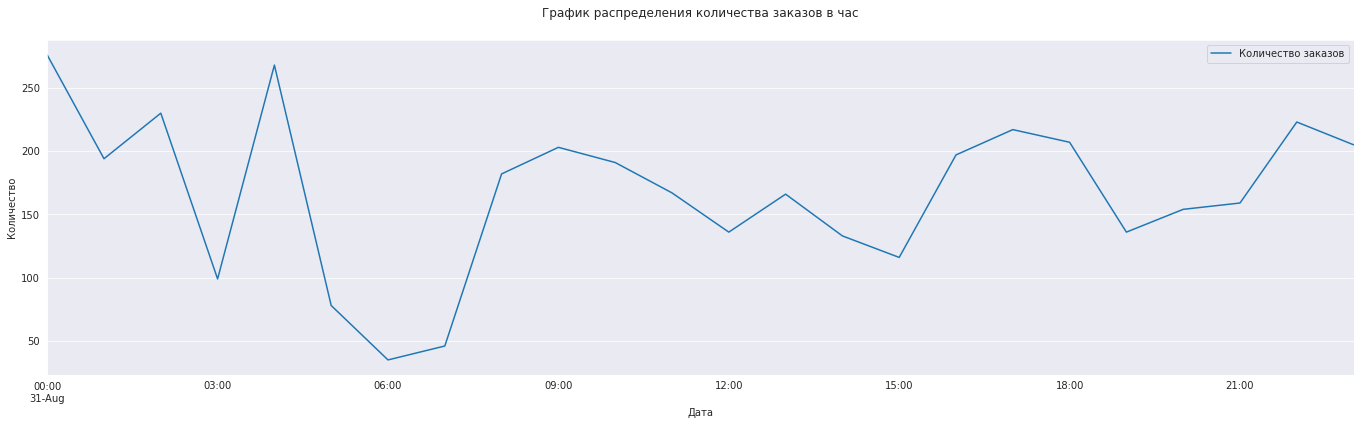

In [19]:
# Вызов функции для построения графика
plot_data_ranges(df_taxi_1h, 'График распределения количества заказов в час', None, None);

**Визуализация распределения количества заказов в час с использованием скользящего среднего**

График За весь срок


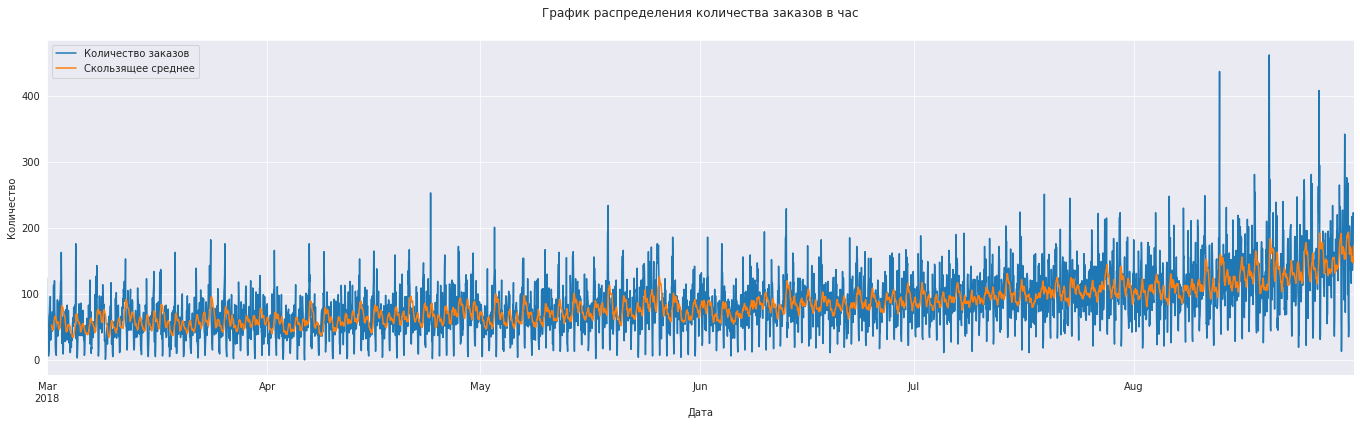

График За месяц


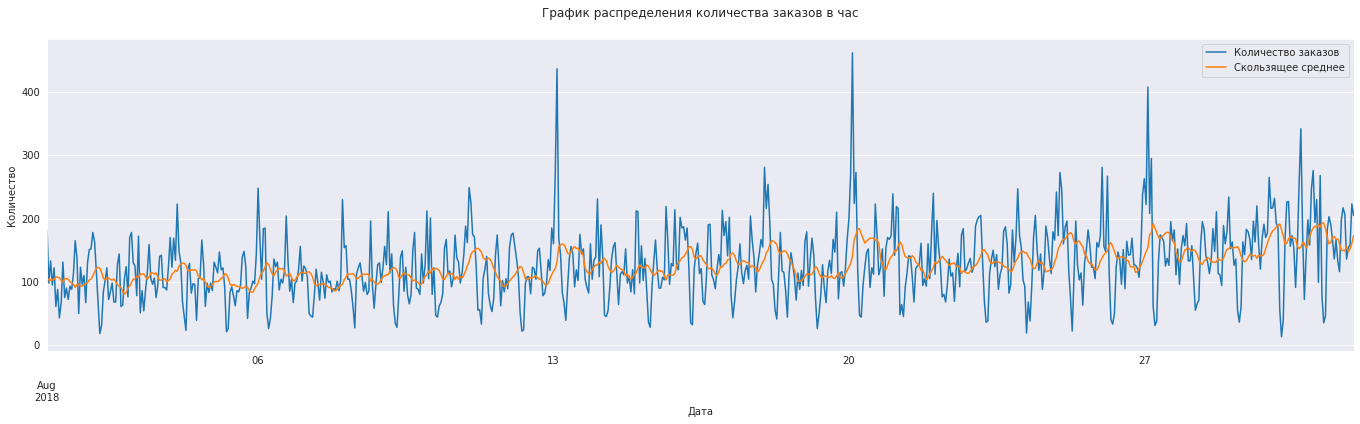

График За неделю


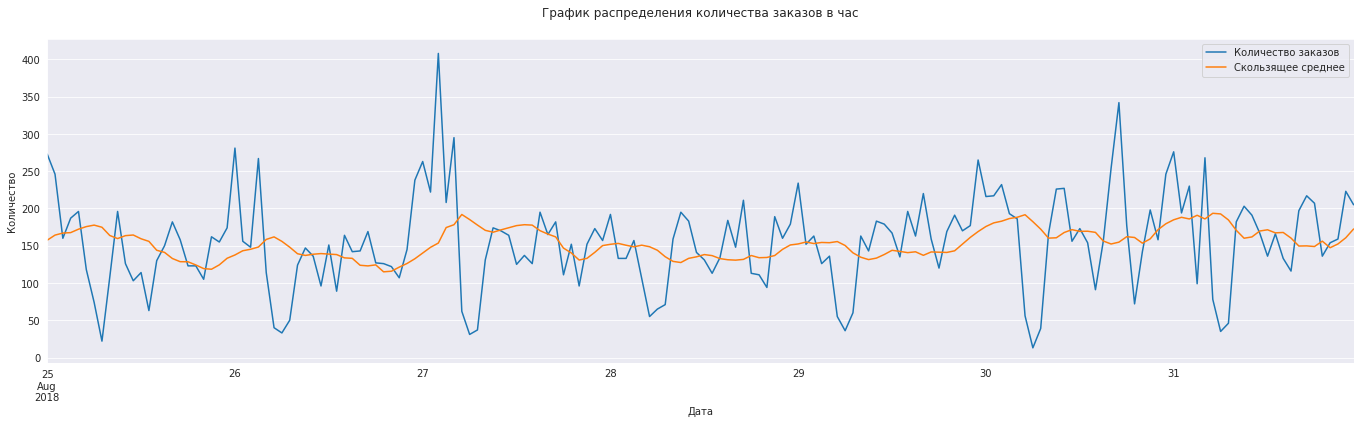

График За день


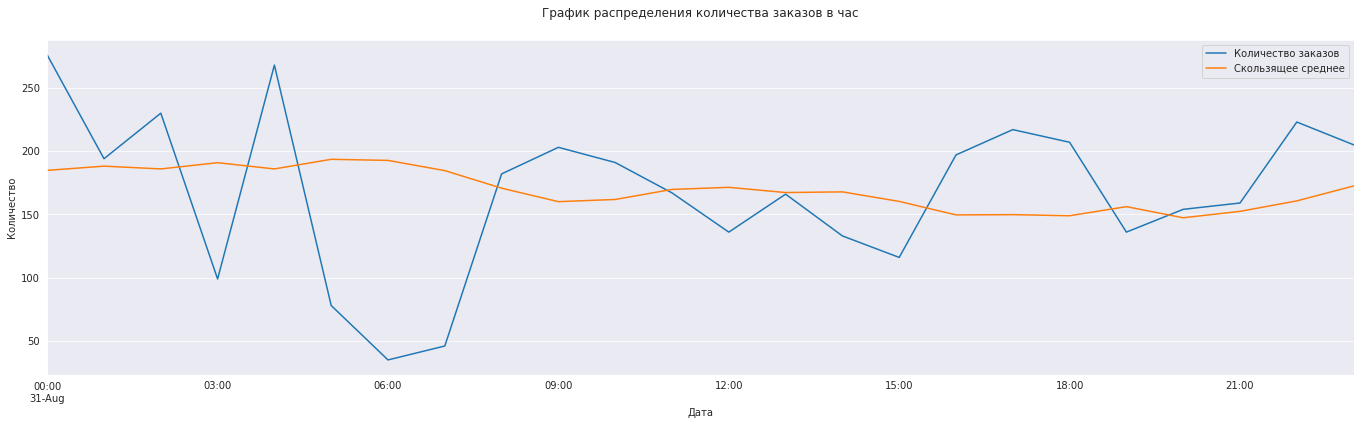

In [20]:
# Вызов функции для построения графика
plot_data_ranges(
    df_taxi_1h, 
    'График распределения количества заказов в час', 
    df_taxi_1h.rolling(15, closed='left').mean(), # Создание скользящего среднего (окно 15)
    'Скользящее среднее'
)

На графике, отображающем данные за весь срок, мы можем наблюдать рост среднего количества заказов. Для более подробного анализа временного ряда количества заказов такси, мы проведем декомпозицию ряда на тренды, сезонность и остаток. Это поможет нам определить наличие тренда и сезонных колебаний в данных заказов.

**Определим тренд**

График За весь срок


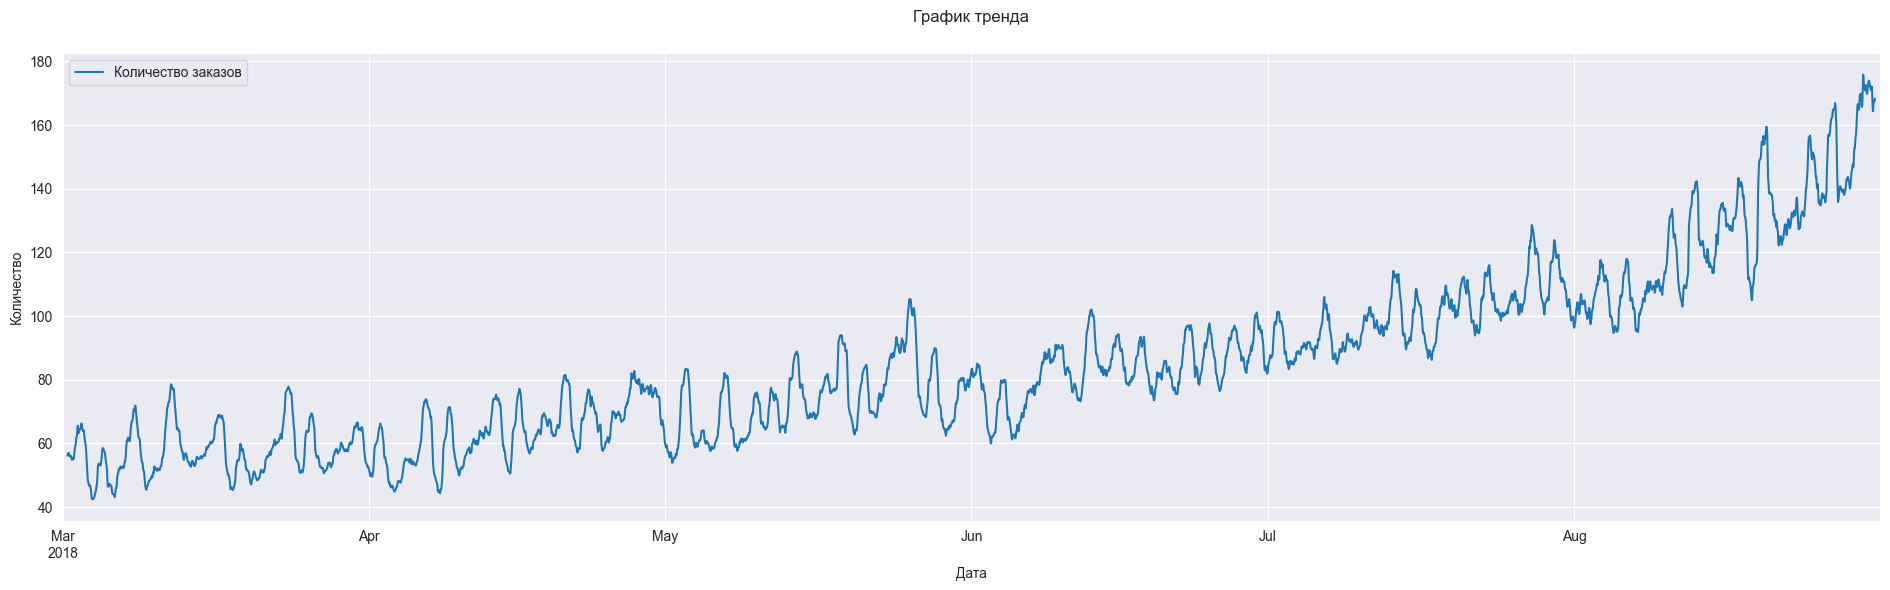

График За месяц


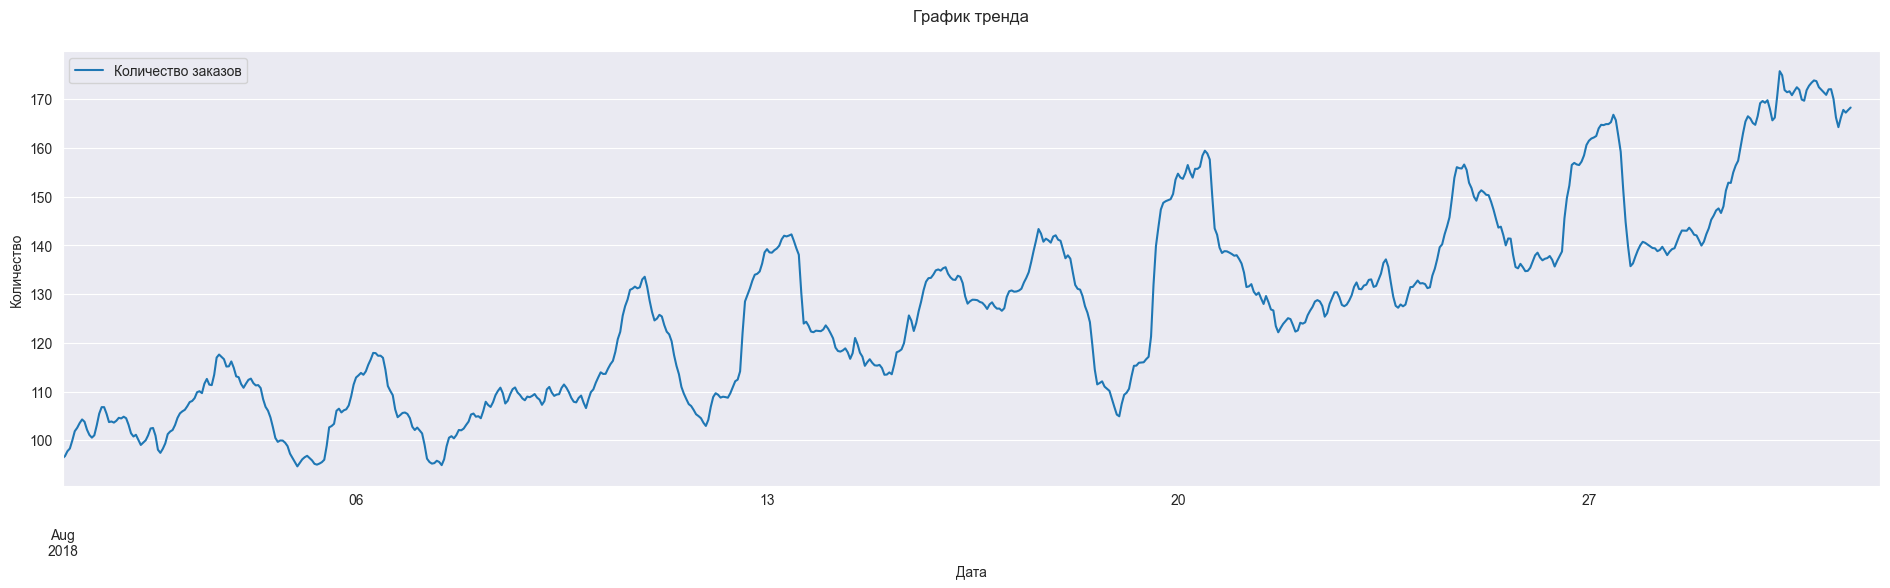

График За неделю


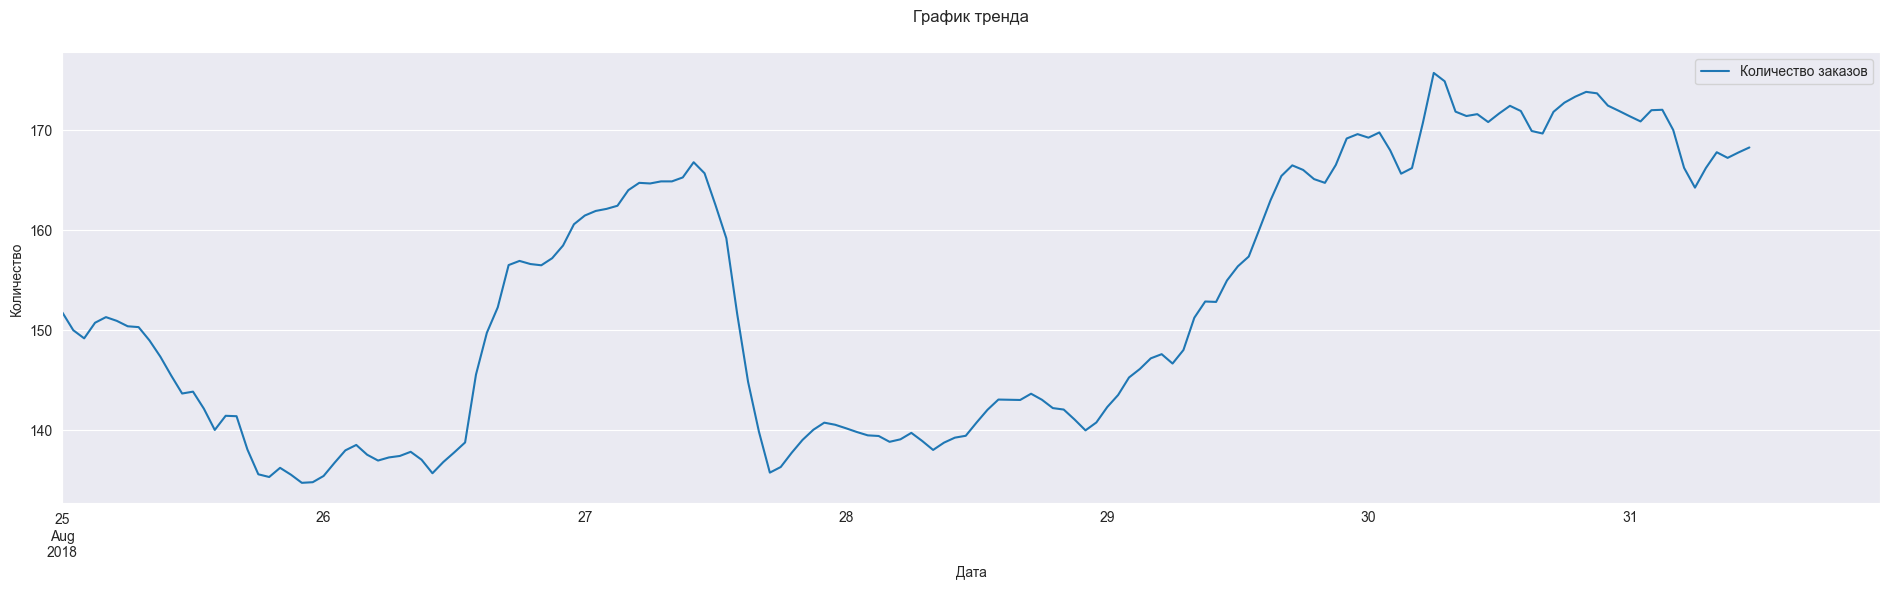

График За день


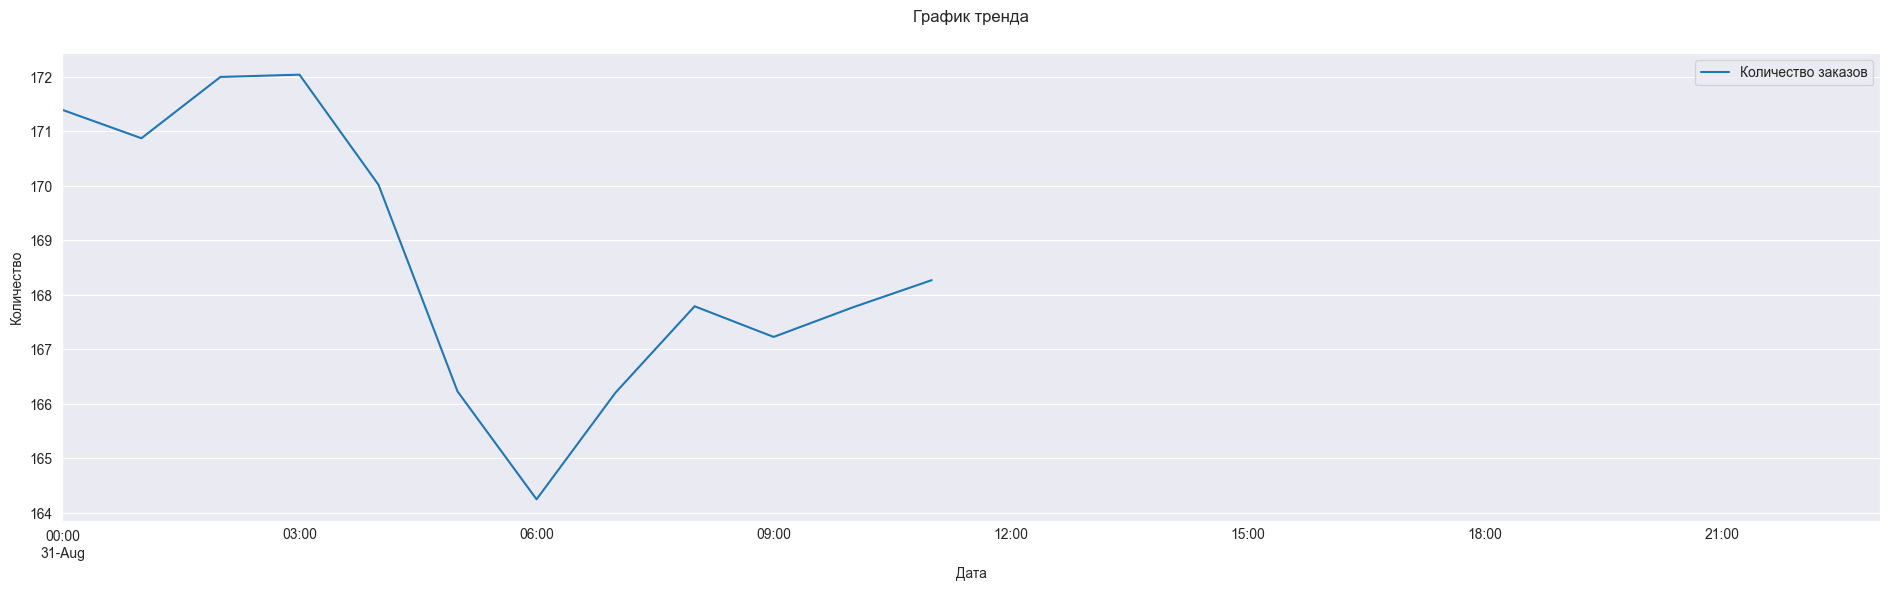

In [12]:
# Вызов функции для построения графика тренда
plot_data_ranges(df_decomposed.trend, 'График тренда', None, None)

Наблюдается явный ежемесячный тренд роста количества заказов с марта 2018 года. Для более детального анализа, определим стандартное отклонение на протяжении всего периода времени.

In [13]:
# Вывод стандартного отклонения для столбца 'trend' в DataFrame df_decomposed
print('Стандартное отклонение: ', round(df_decomposed.trend.std(), 2))

Стандартное отклонение:  26.31


**Определим сезонность**

График За весь срок


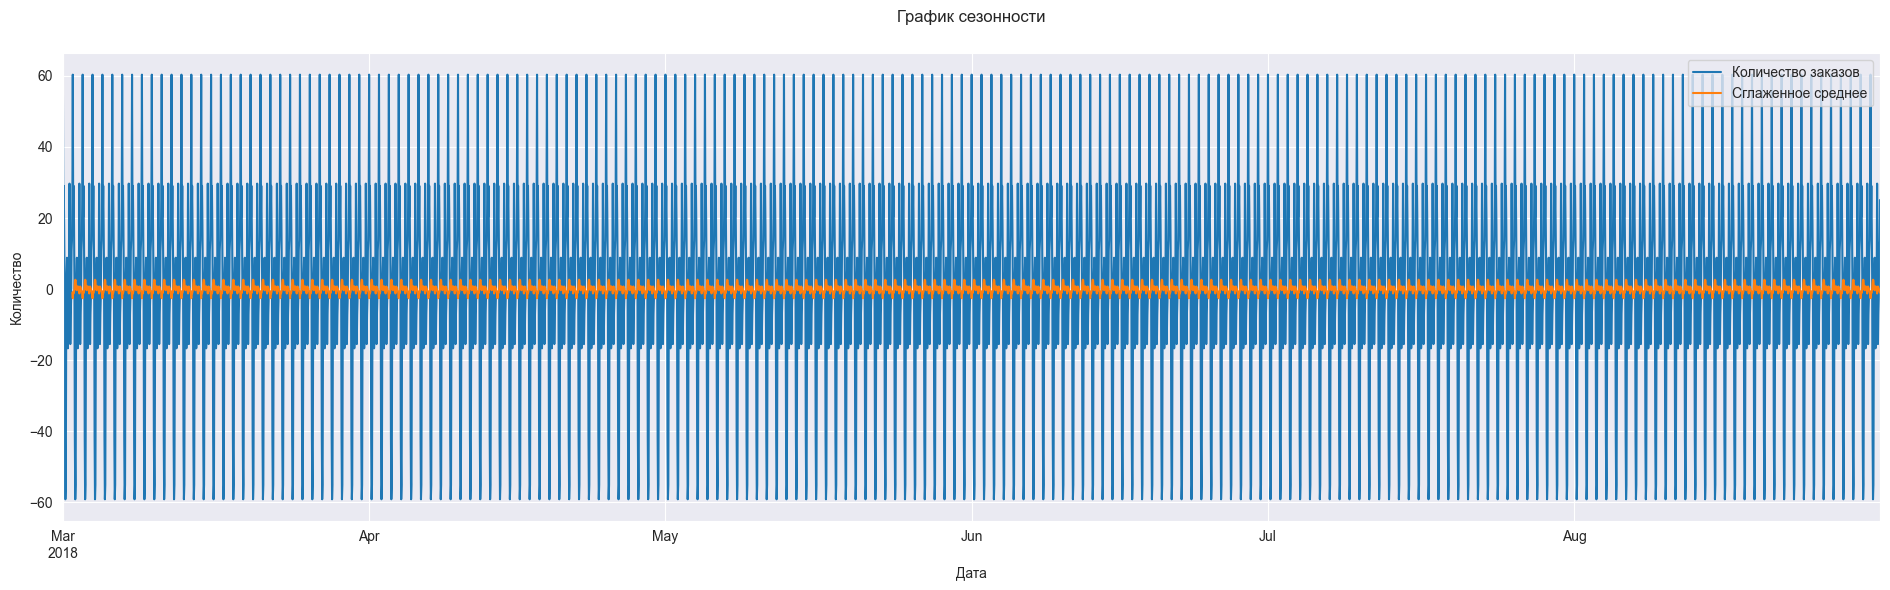

График За месяц


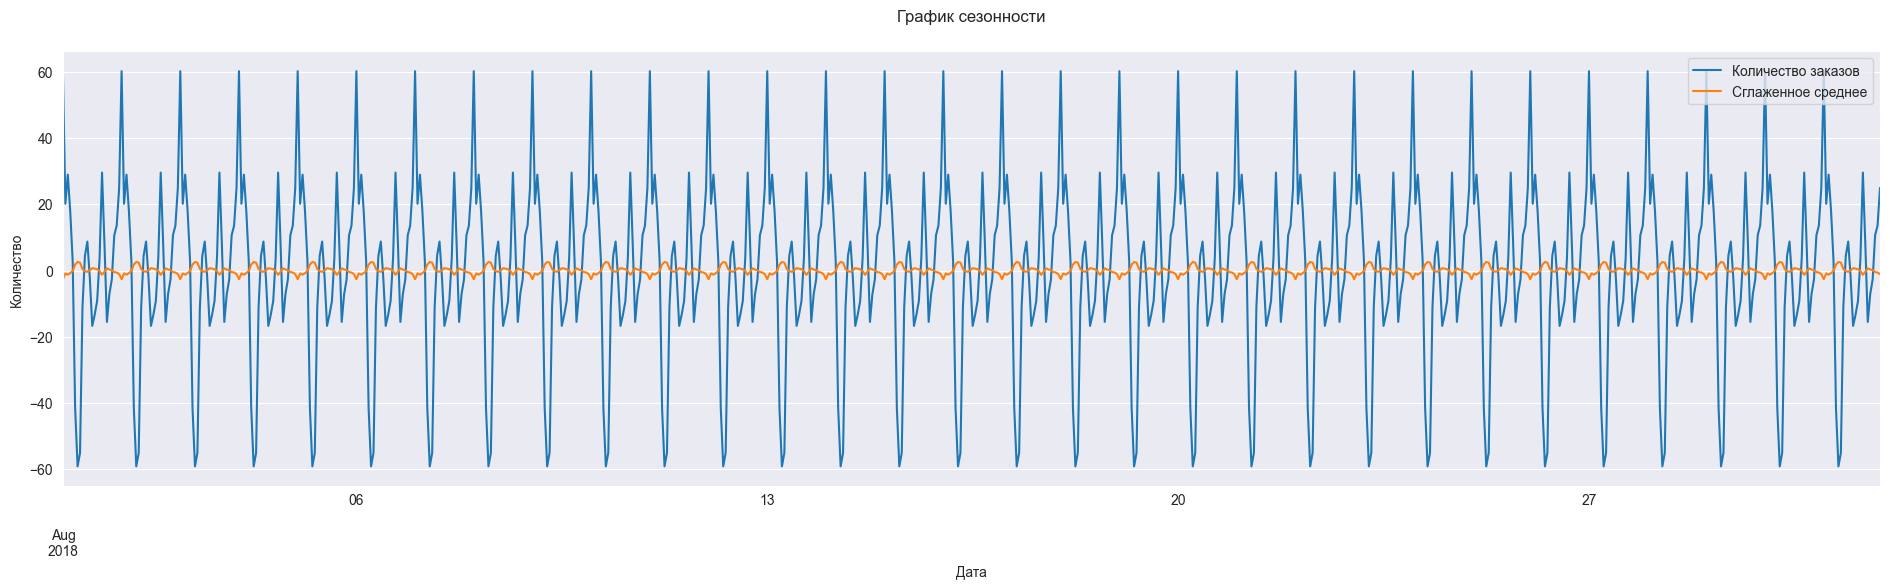

График За неделю


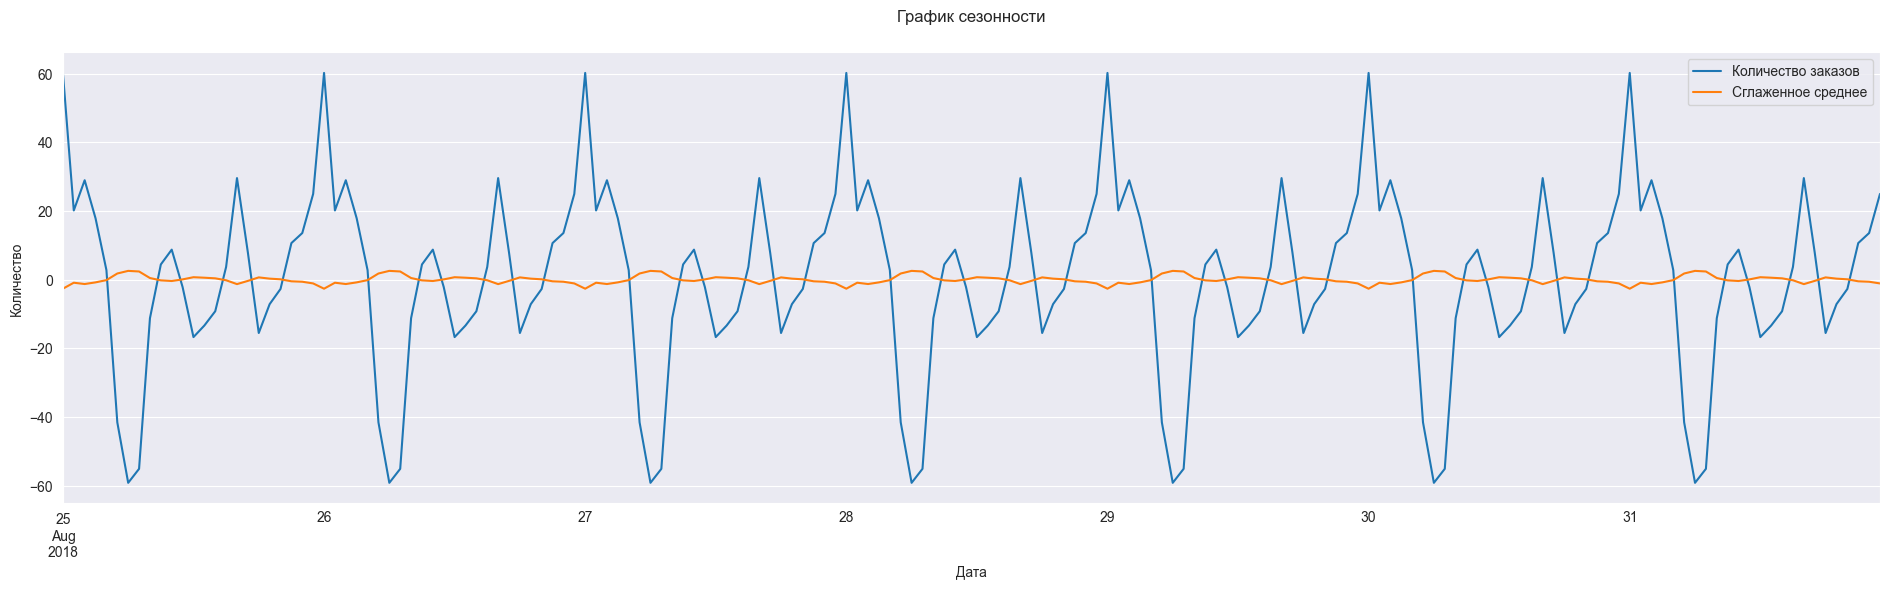

График За день


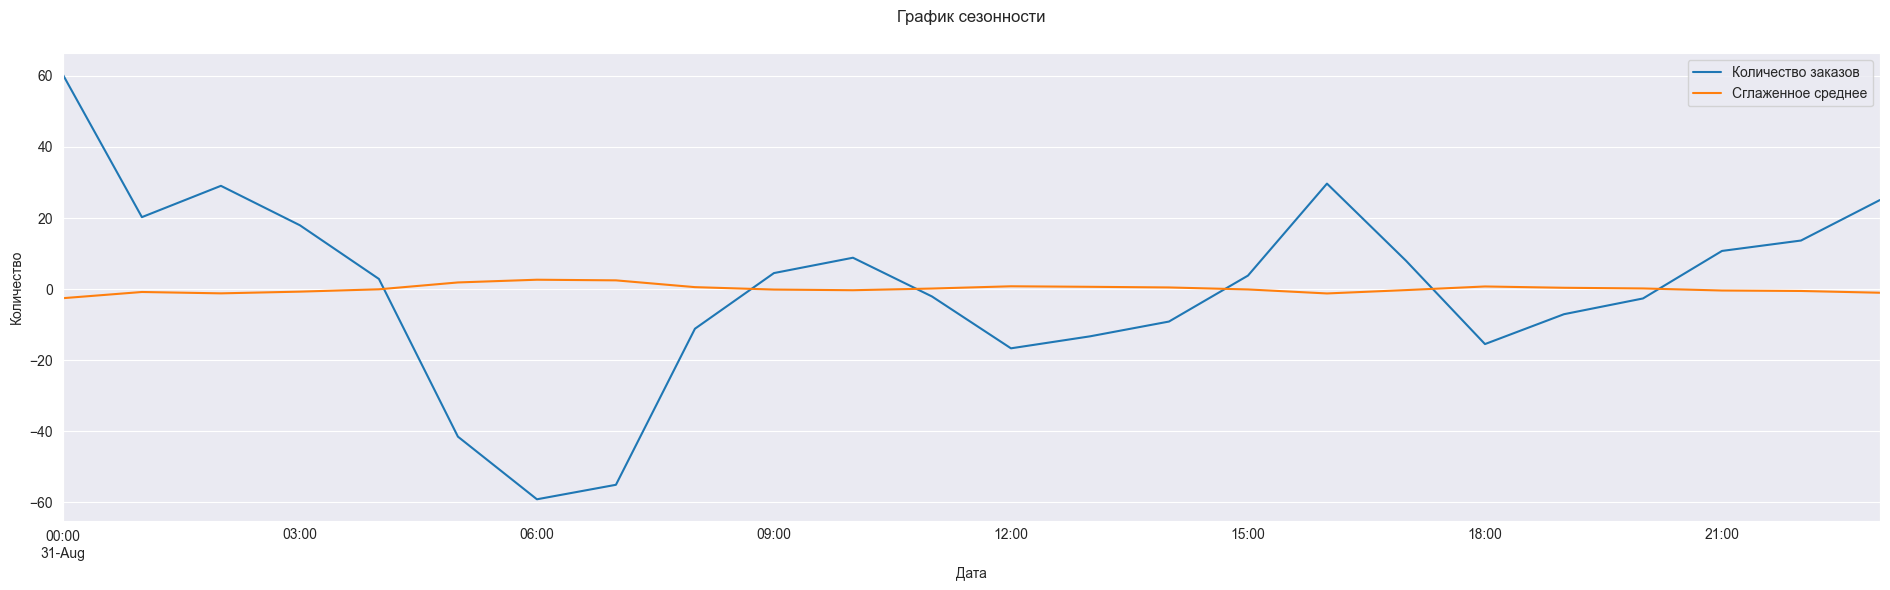

In [14]:
# Вызов функции для построения графика сезонности с скользящим средним
plot_data_ranges(df_decomposed.seasonal, 'График сезонности', df_decomposed.seasonal.rolling(window=23, closed='left').mean(), 'Сглаженное среднее' )

Анализируя данные за день, можно заметить следующие закономерности:

- Наблюдается падение заказов с 10 до 12, с 16 до 18 и достижение минимума около 6 утра.
- Заказы растут с 6 до 10, с 12 до 16 и достигают максимума около 00:00.

Эти закономерности повторяются каждый день и указывают на наличие циклических паттернов в данных.

**Оценка стационарности**

Проведем оценку стационарности основного ряда ресэмплированному по одному часу. Для оценки стационарности используется тест Дики-Фуллера, который вычисляет p-value.  Затем происходит проверка гипотез на уровнях значимости 1% и 5%. Если p-value меньше выбранного уровня значимости, то отвергается нулевая гипотеза и делается вывод, что ряд стационарен на соответствующем уровне значимости. В противном случае, нулевая гипотеза не отвергается, и делается вывод о нестационарности ряда.

Таким образом, в данном коде мы проверяем стационарность ряда и выводим результаты на уровнях значимости 1% и 5%.

In [15]:
# Применение теста Дики-Фуллера на стационарность ряда
result = adfuller(df_taxi_1h.dropna())
# result = adfuller(df_decomposed.resid.dropna())

# Извлечение p-value из результата теста
p_value = result[1]

# Уровень значимости
alpha_1 = 0.01
alpha_5 = 0.05

# Проверка гипотез и вывод результатов
if p_value < alpha_1:
    print("Ряд стационарен на уровне значимости 1%. Отвергаем нулевую гипотезу.")
else:
    print("Ряд нестационарен на уровне значимости 1%. Не отвергаем нулевую гипотезу.")
if p_value < alpha_5:
    print("Ряд стационарен на уровне значимости 5%. Отвергаем нулевую гипотезу.")
else:
    print("Ряд нестационарен на уровне значимости 5%. Не отвергаем нулевую гипотезу.")

Ряд нестационарен на уровне значимости 1%. Не отвергаем нулевую гипотезу.
Ряд стационарен на уровне значимости 5%. Отвергаем нулевую гипотезу.


По результатам теста Дики-Фуллера на стационарность временного ряда мы получили следующие результаты:

- На уровне значимости 5% мы отвергаем нулевую гипотезу о нестационарности ряда, что говорит о том, что ряд является стационарным на этом уровне значимости.

- Однако, на уровне значимости 1% мы не отвергаем нулевую гипотезу, что означает, что на этом более строгом уровне значимости ряд не является стационарным.

Таким образом, можно сделать вывод, что временной ряд является стационарным на более высоком уровне значимости (5%), но не является стационарным на более строгом уровне значимости (1%). Для достижения уровня значимости в 1% следует прменить дифференцирование к ряду `df_taxi_1h`.

In [16]:
# Применение дифференцирования к ряду
df_taxi_1h_diff = df_taxi_1h.diff().dropna()

# Проверка стационарности преобразованного ряда
result = adfuller(df_taxi_1h_diff)

# Извлечение p-value из результата теста
p_value = result[1]

# Уровень значимости
alpha = 0.01

# Проверка гипотез и вывод результатов
if p_value < alpha:
    print("Ряд стационарен после дифференцирования. Отвергаем нулевую гипотезу.")
else:
    print("Ряд нестационарен после дифференцирования. Не отвергаем нулевую гипотезу.")

Ряд стационарен после дифференцирования. Отвергаем нулевую гипотезу.


После применения дифференцирования к ряду `df_taxi_1h` удалось достичь стационарности данных. Тест Дики-Фуллера подтвердил статистическую значимость и отверг нулевую гипотезу о нестационарности ряда. Это означает, что после дифференцирования данные стали подходящими для построения модели предсказания.

График За весь срок


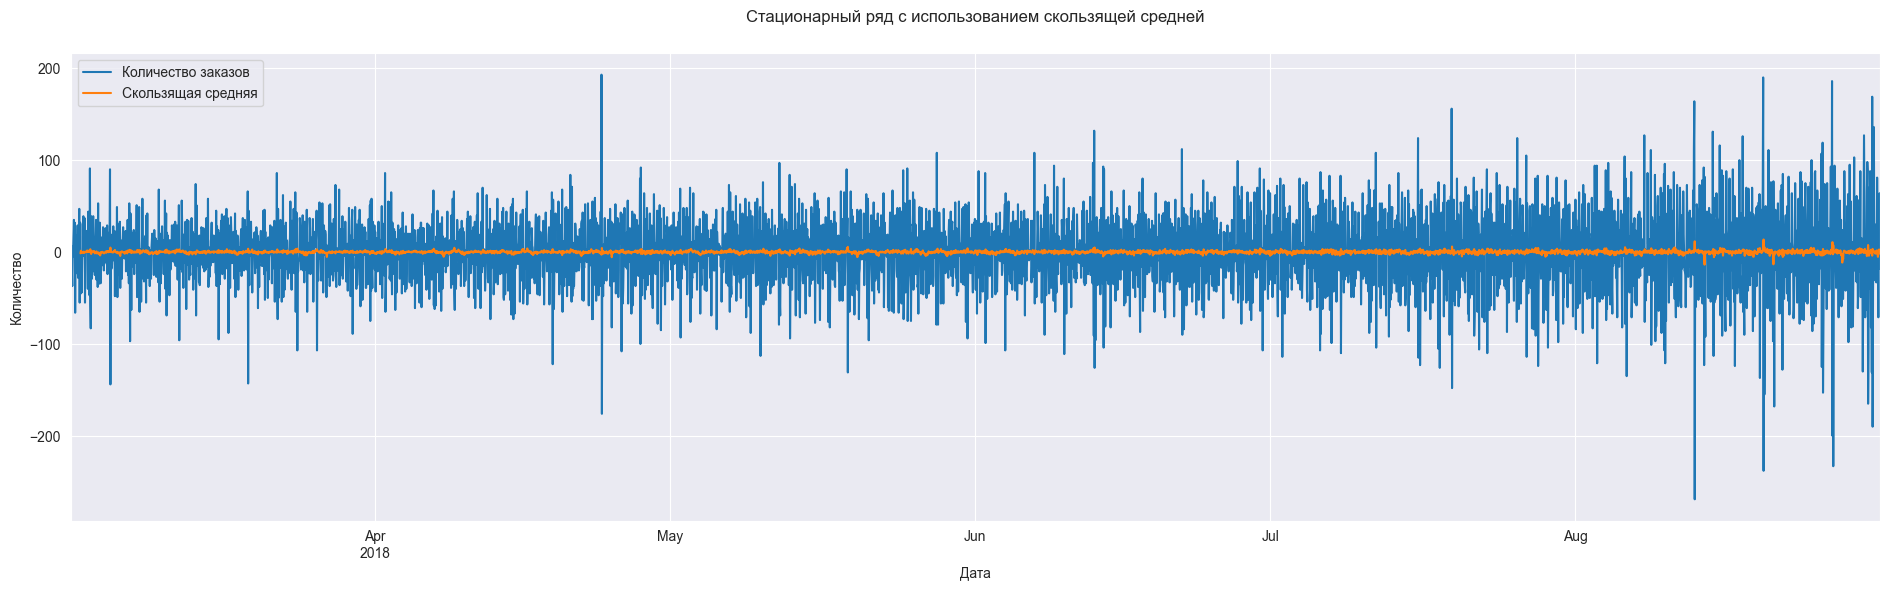

График За месяц


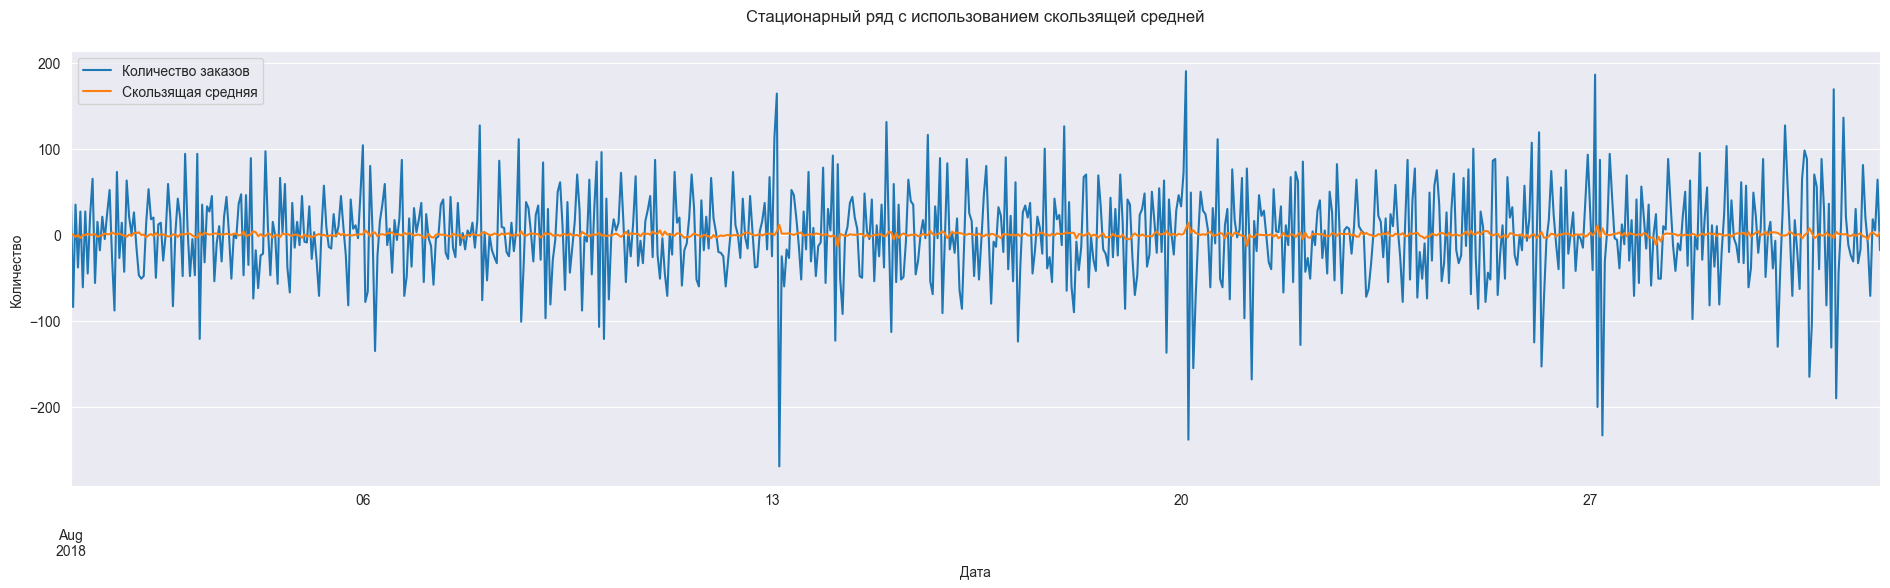

График За неделю


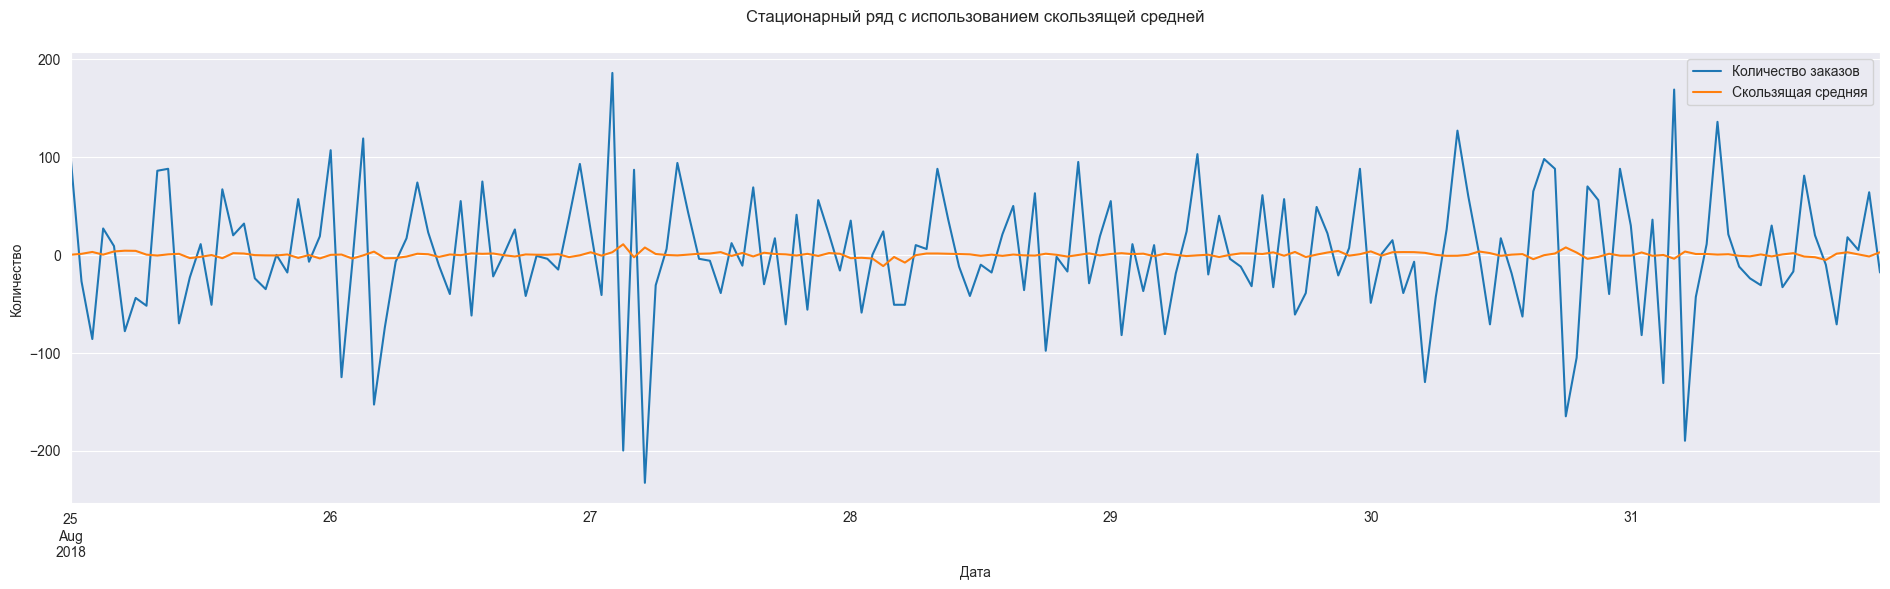

График За день


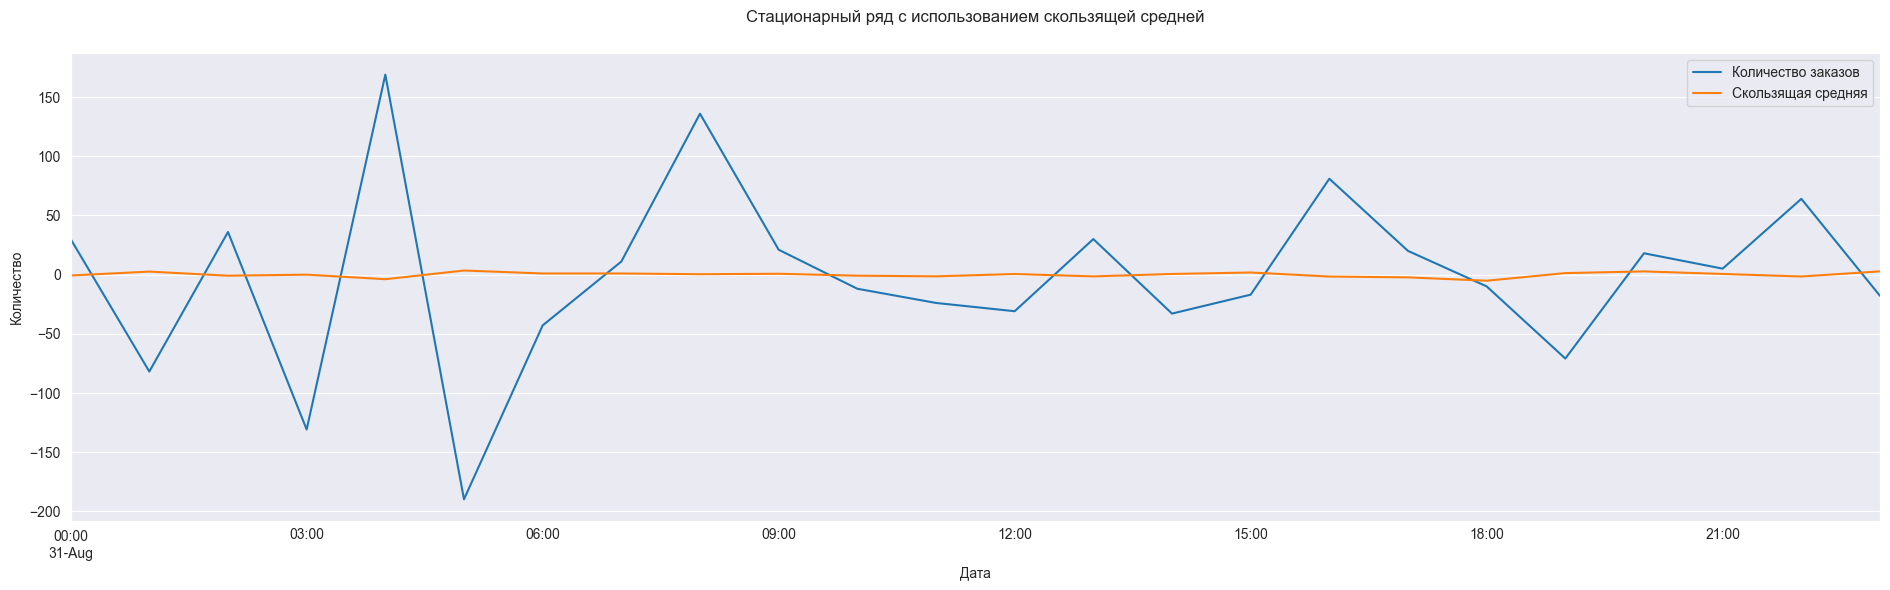

In [17]:
# Вызов функции для построения графика стационарного ряда с использованием скользящей средней
plot_data_ranges(df_taxi_1h_diff, 'Стационарный ряд с использованием скользящей средней', df_taxi_1h_diff.rolling(window=24, closed='left').mean(), 'Скользящая средняя')

После применения дифференцирования ряда и проверки стационарности с помощью теста Дики-Фуллера, мы можем утверждать, что полученный ряд стационарен. На графике мы видим ряд после дифференцирования, а также на графике представлена скользящая средняя. Мы можем заметить, что ряд колеблется вокруг некоторого среднего значения, и скользящая средняя показывает плавное сглаживание этих колебаний. С учетом контекста проекта, связанного с аэропортами, колебания в ряде могут отражать пиковые периоды спроса на такси, связанные с прибытием и отправлением пассажиров в аэропортах. 

**Остаток декомпозиции**

График За весь срок


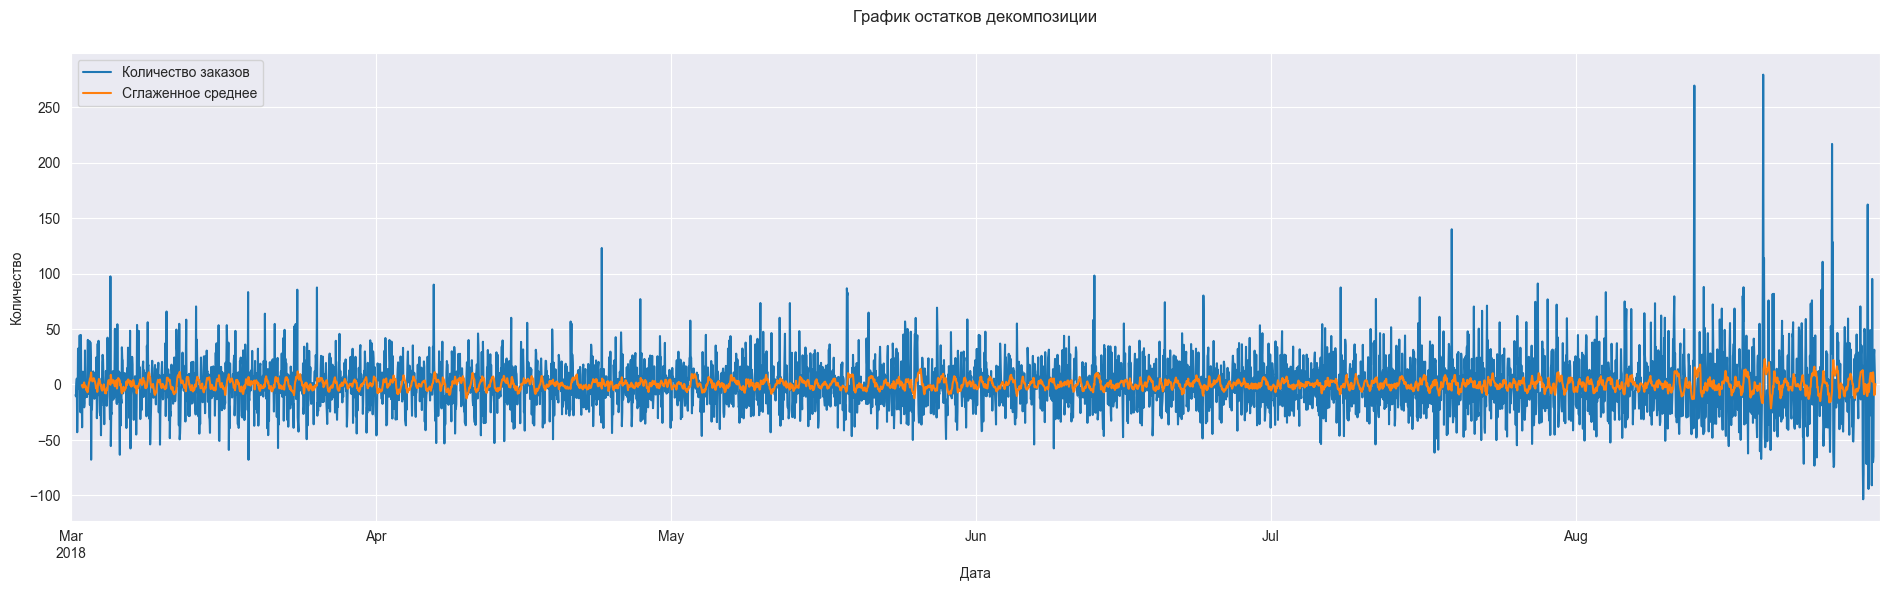

График За месяц


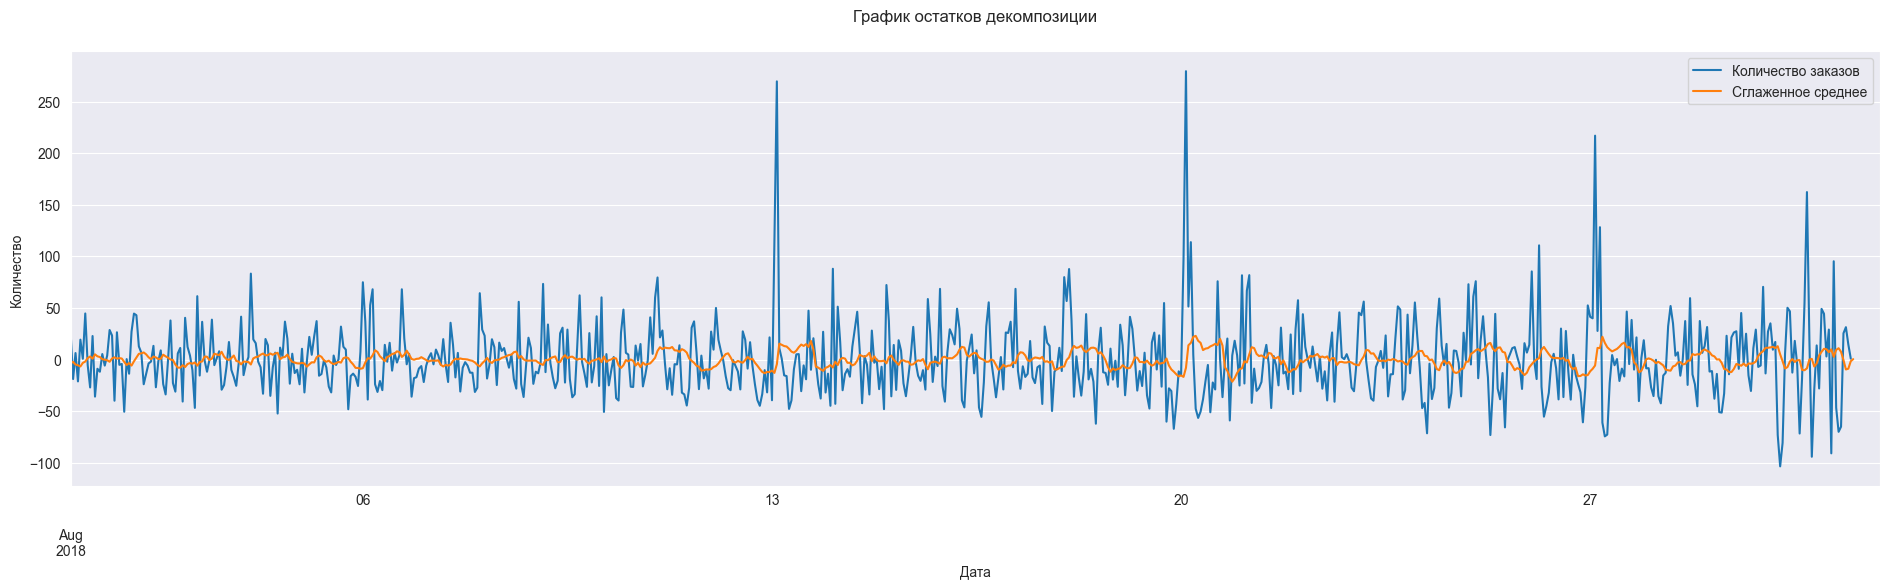

График За неделю


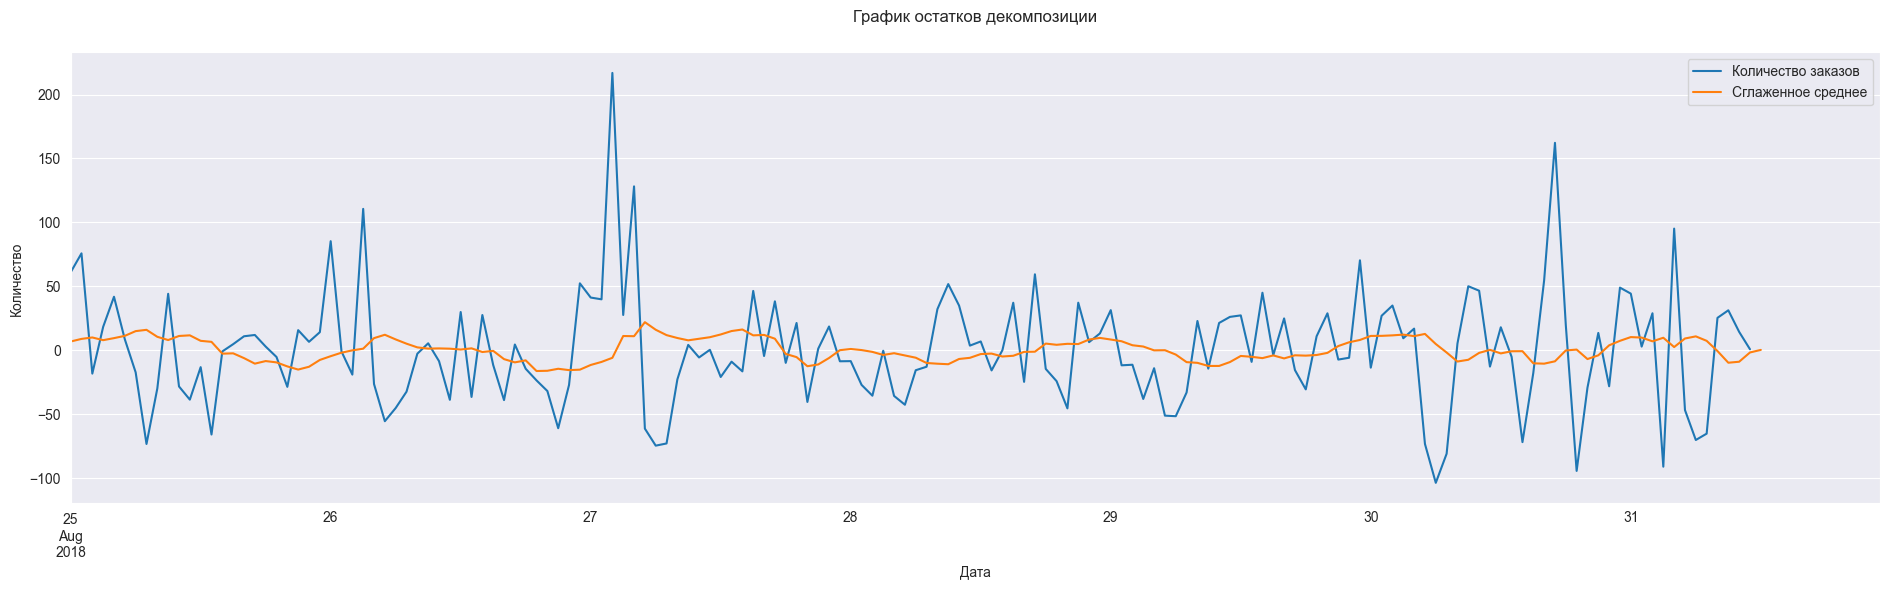

График За день


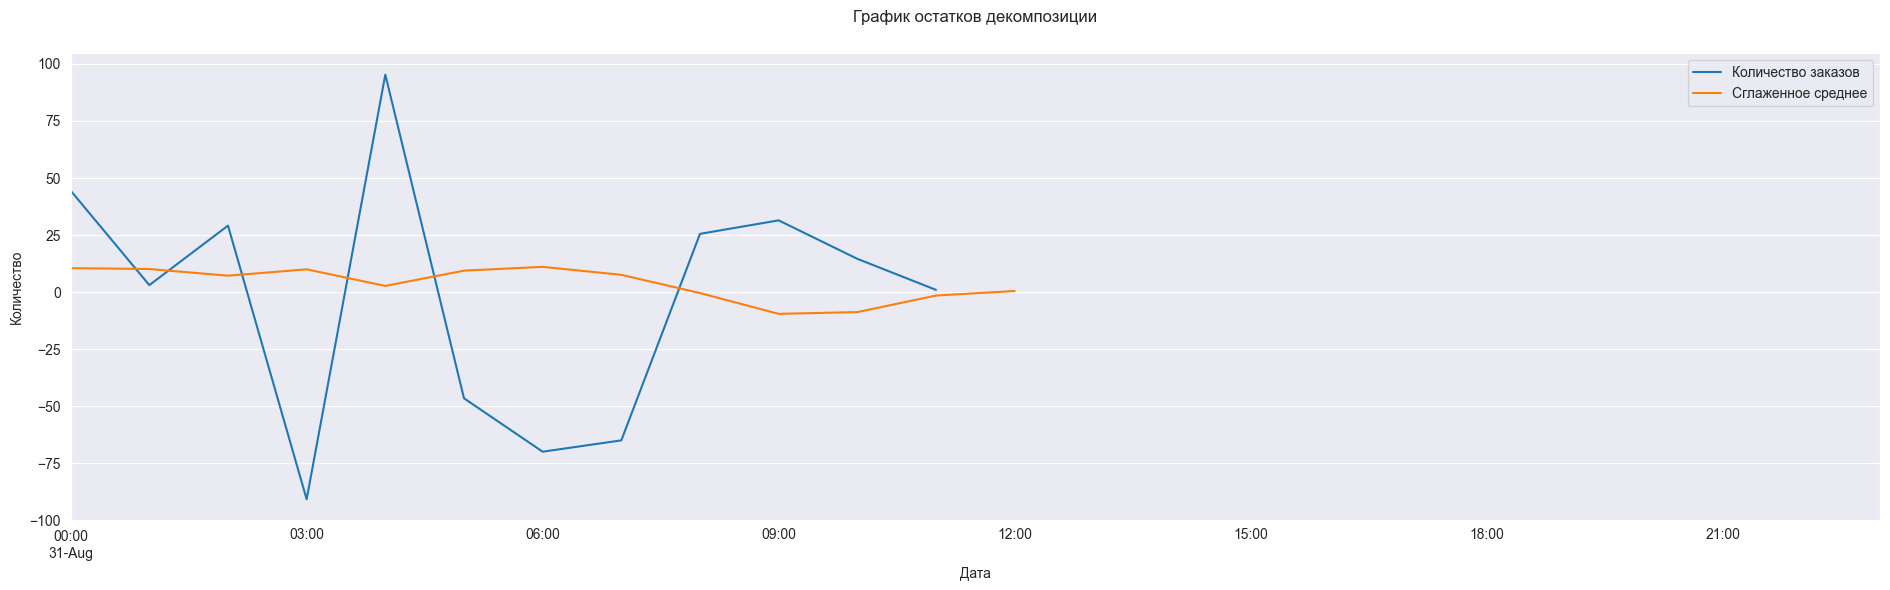

In [18]:
# Вызов функции для построения графика остатков декомпозиции с использованием скользящей средней
plot_data_ranges(df_decomposed.resid, 'График остатков декомпозиции', df_decomposed.resid.rolling(window=15, closed='left').mean(), 'Сглаженное среднее')

На графике отображены остатки декомпозиции, которые представляют собой случайную компоненту или шум в данных. Они представляют оставшуюся вариацию в ряде после удаления тренда и сезонности. Нет явной закономерности или систематического шаблона в остатках, что указывает на отсутствие явных недостатков в моделировании или пропущенных факторов. Остатки выглядят случайными и не содержат явных структурных или систематических отклонений от среднего значения.

**График разностей временного ряда с скользящим средним и стандартным отклонением**

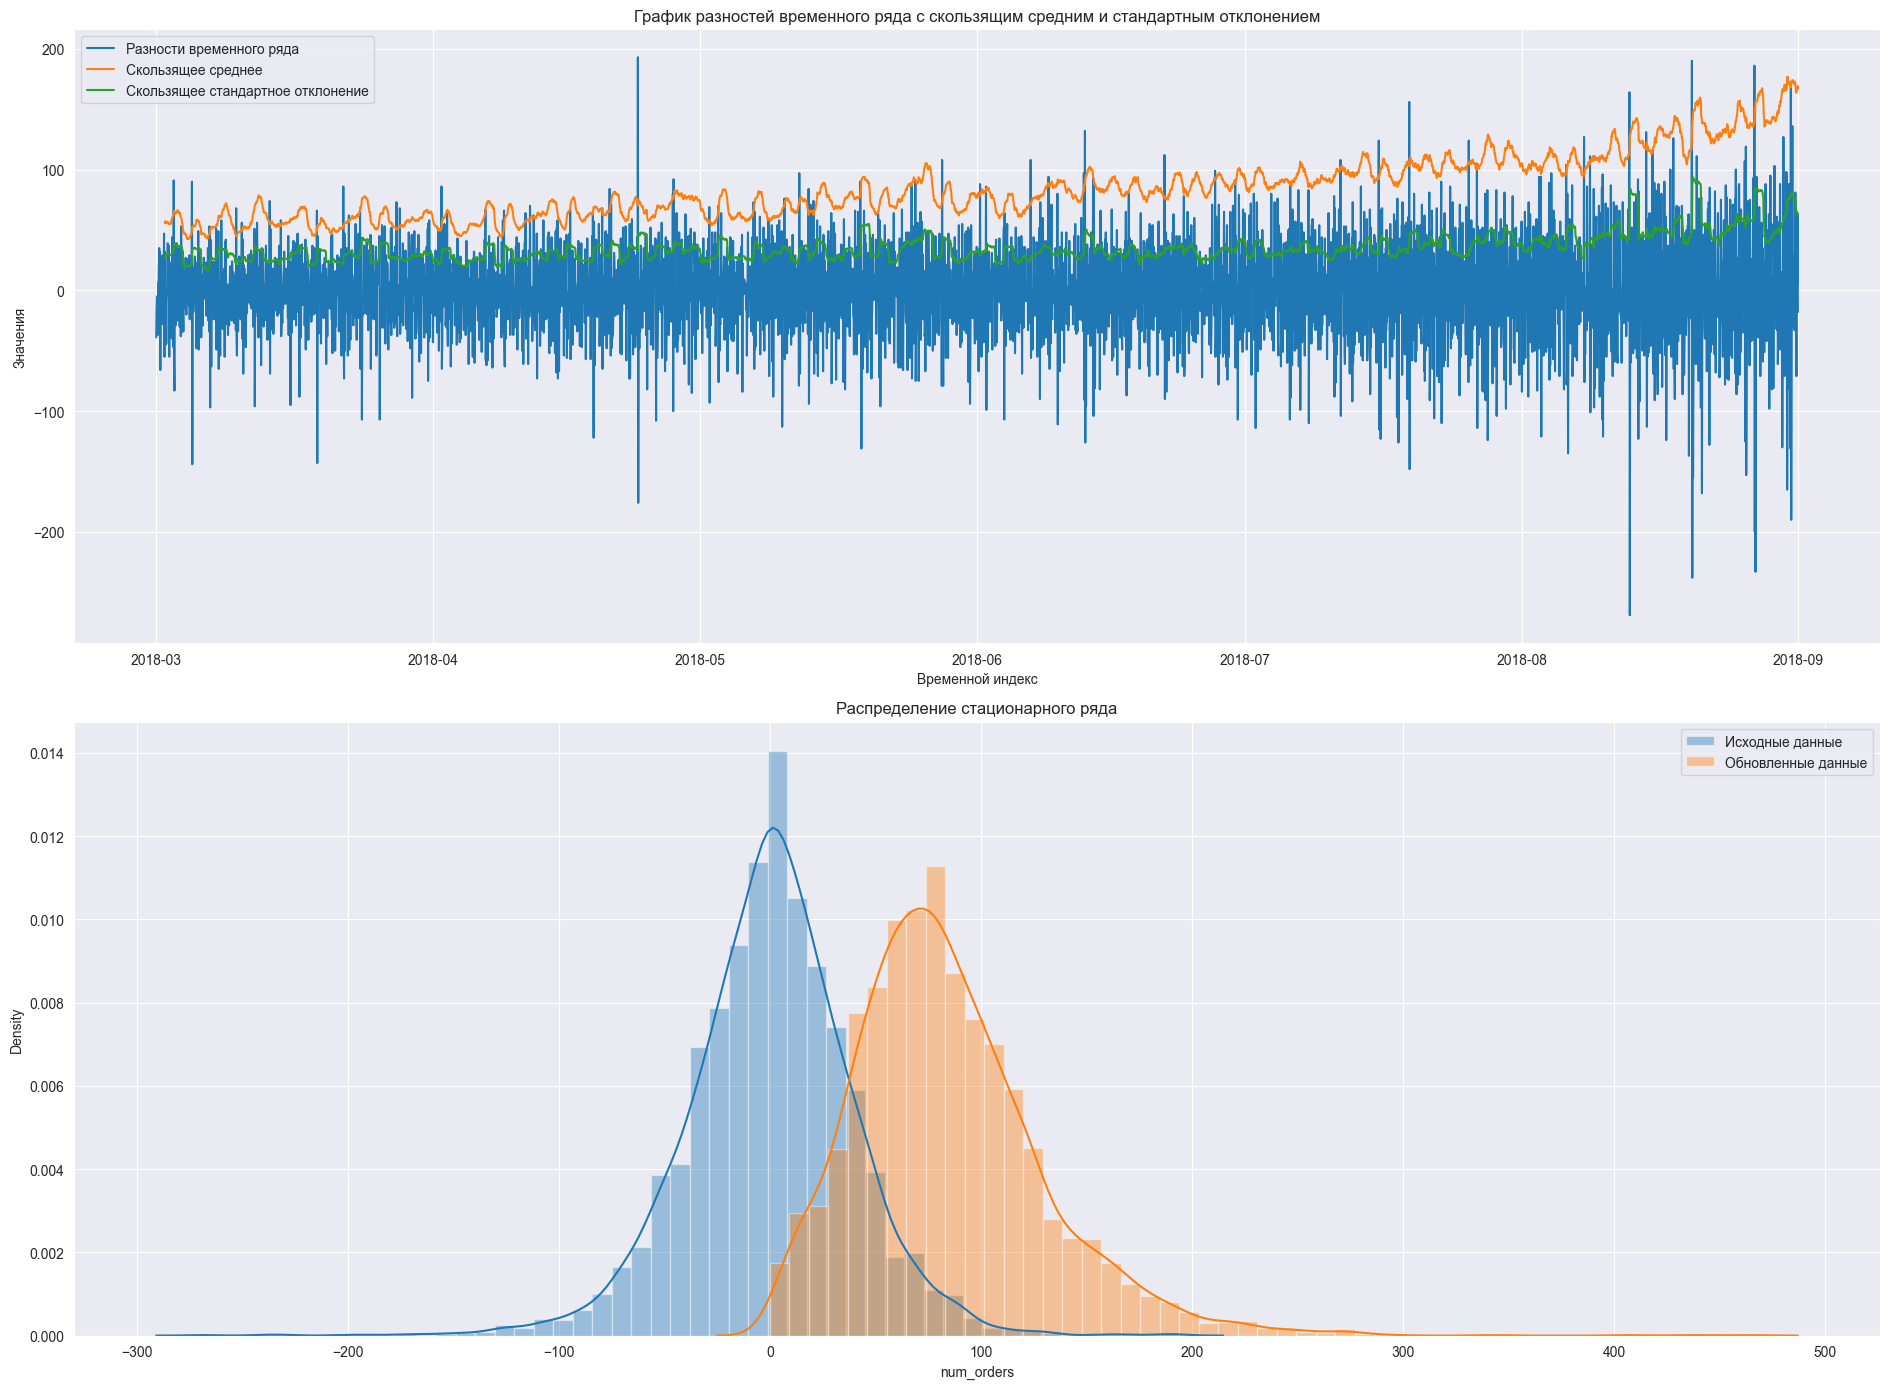

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(19, 14))

# Вычисление разностей временного ряда
df_taxi_1h_diff['mean'] = df_taxi_1h['num_orders'].rolling(window=24, closed='left').mean()  # Вычисление скользящего среднего
df_taxi_1h_diff['std'] = df_taxi_1h['num_orders'].rolling(window=24, closed='left').std()  # Вычисление скользящего стандартного отклонения
data_upd = df_taxi_1h - df_taxi_1h_diff

# График разностей временного ряда с скользящим средним и стандартным отклонением
axes[0].plot(df_taxi_1h_diff.index, df_taxi_1h_diff['num_orders'], label='Разности временного ряда')
axes[0].plot(df_taxi_1h_diff.index, df_taxi_1h_diff['mean'], label='Скользящее среднее')
axes[0].plot(df_taxi_1h_diff.index, df_taxi_1h_diff['std'], label='Скользящее стандартное отклонение')
axes[0].set_title('График разностей временного ряда с скользящим средним и стандартным отклонением')
axes[0].set_xlabel('Временной индекс')
axes[0].set_ylabel('Значения')
axes[0].legend()

# Распределение стационарного ряда
sns.distplot(df_taxi_1h_diff['num_orders'], ax=axes[1], label='Исходные данные')
sns.distplot(data_upd['num_orders'], ax=axes[1], label='Обновленные данные')
axes[1].set_title('Распределение стационарного ряда')
axes[1].legend()

plt.tight_layout()
plt.show()

Применение разностей временного ряда позволило получить стационарный временной ряд, где значения более стабильны и распределение ближе к нормальному. Это может быть полезным для дальнейшего анализа и прогнозирования, так как стационарные ряды обладают более предсказуемыми свойствами.

**Вывод:**

После анализа исходных данных мы обнаружили следующее:

- Тренд: Наблюдается явное возрастание тренда, что указывает на нестационарность временного ряда. Это подтверждается как графиком тренда, так и графиком ресемплированных данных по часам. Даже после удаления тренда и сезонности, на графике остатков все еще присутствуют выбросы.

- Сезонность: Присутствует явная суточная сезонность:
    - Наблюдается падение заказов с 10 до 12, с 16 до 18 и достижение минимума около 6 утра.
    - Заказы растут с 6 до 10, с 12 до 16 и достигают максимума около 00:00.

- Дни недели: Количество заказов различается в зависимости от дня недели, поэтому необходимо учесть этот фактор при дальнейшем анализе.

## Обучение

**Признаки для обучения моделей:**

Для обучения моделей нам понадобятся следующие признаки:

1. `День недели:` На графике тренда за месяц видна зависимость от дня недели, поэтому включение этого признака позволит модели учесть сезонность в данных.

2. `Час:` Целью является предсказание данных на определенный час, поэтому включение признака "час" позволит модели учесть суточную сезонность.

3. `Значения lag (запаздывание):` Добавление значений предыдущих периодов (например, предыдущего часа или дня) позволит модели учесть зависимость от предыдущих наблюдений и возможные тренды.

4. `Скользящее среднее:` Включение скользящего среднего (rolling mean) позволит модели учесть сглаживание данных и сезонные колебания.

Для добавления этих признаков в датасет можно создать функцию, которая будет генерировать соответствующие признаки на основе исходных данных.

**Генерация признаков для обучения модели прогнозирования спроса на такси**

In [20]:
def create_features(data, max_lag, rolling_mean_size):
    """
    Создает новые признаки на основе исходных данных.

    Аргументы:
    - data: исходные данные
    - max_lag: максимальное значение лага
    - rolling_mean_size: размер окна для скользящего среднего

    Возвращает:
    - data: обновленные данные с добавленными признаками
    """
    # Создаем копию данных
    data = data.copy()
    
    # Добавляем признаки дня недели, месяца, дня и часа
    data['dayofweek'] = data.index.dayofweek
#     data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour

    # Создаем лаги для заданного числа максимальных лагов
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    # Создаем скользящее среднее для заданного размера окна
    data['rolling_mean'] = data['num_orders'].rolling(rolling_mean_size, closed='left').mean()
    
    # Возвращаем обновленные данные с добавленными признаками
    return data

In [21]:
# Вызов функции для создания признаков на основе исходных данных
data_with_features = create_features(df_taxi_1h, max_lag=12, rolling_mean_size=24)
# Вывод первых 5 строк DataFrame с новыми признаками
data_with_features.head(5)

num_orders  dayofweek  day  hour  lag_1  lag_2  lag_3  \
datetime                                                                     
2018-03-01 00:00:00         124          3    1     0    NaN    NaN    NaN   
2018-03-01 01:00:00          85          3    1     1 124.00    NaN    NaN   
2018-03-01 02:00:00          71          3    1     2  85.00 124.00    NaN   
2018-03-01 03:00:00          66          3    1     3  71.00  85.00 124.00   
2018-03-01 04:00:00          43          3    1     4  66.00  71.00  85.00   

                     lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  lag_11  \
datetime                                                                        
2018-03-01 00:00:00    NaN    NaN    NaN    NaN    NaN    NaN     NaN     NaN   
2018-03-01 01:00:00    NaN    NaN    NaN    NaN    NaN    NaN     NaN     NaN   
2018-03-01 02:00:00    NaN    NaN    NaN    NaN    NaN    NaN     NaN     NaN   
2018-03-01 03:00:00    NaN    NaN    NaN    NaN    NaN    NaN     NaN     NaN   
2018-03-01 04:00:00 124.00    NaN    NaN    NaN    NaN    NaN     NaN     NaN   

                     lag_12  rolling_mean  
datetime                                   
2018-03-01 00:00:00     NaN           NaN  
2018-03-01 01:00:00     NaN           NaN  
2018-03-01 02:00:00     NaN           NaN  
2018-03-01 03:00:00     NaN           NaN  
2018-03-01 04:00:00     NaN           NaN

In [22]:
# Вывод первых 5 строк DataFrame df_taxi_1h
df_taxi_1h.head()

num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43

In [23]:
# Вывод первых 5 строк DataFrame df_taxi_1h_diff
df_taxi_1h_diff.head()

num_orders  mean  std
datetime                                  
2018-03-01 01:00:00      -39.00   NaN  NaN
2018-03-01 02:00:00      -14.00   NaN  NaN
2018-03-01 03:00:00       -5.00   NaN  NaN
2018-03-01 04:00:00      -23.00   NaN  NaN
2018-03-01 05:00:00      -37.00   NaN  NaN

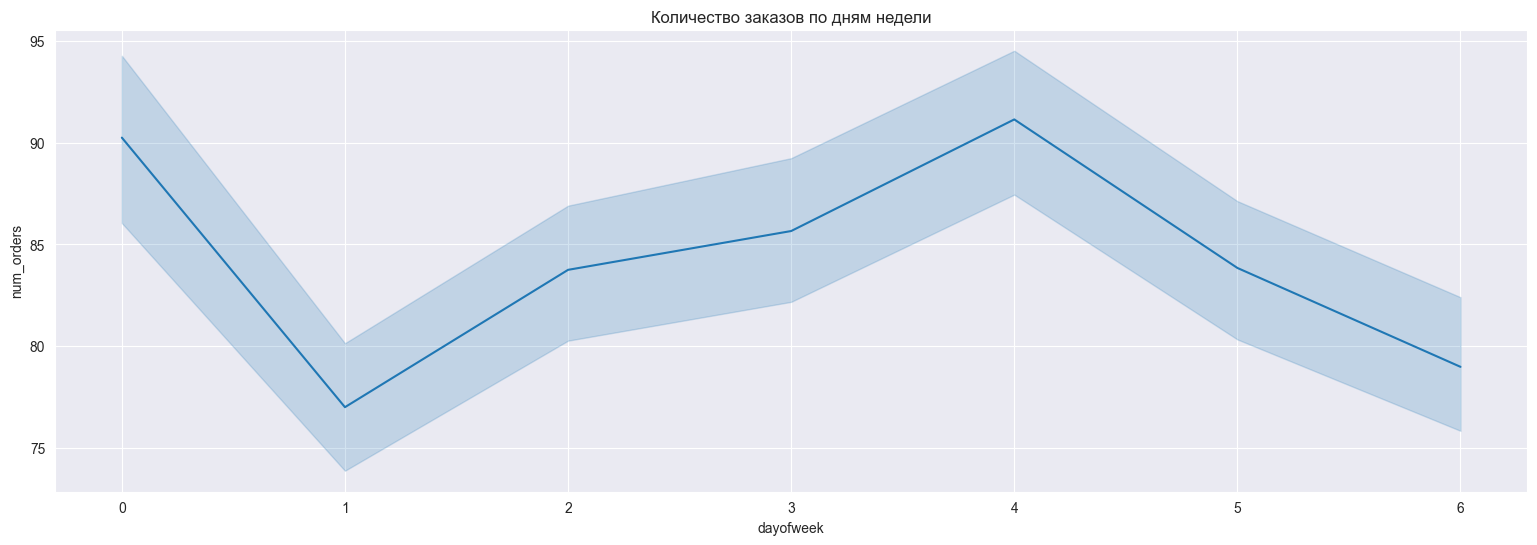

In [24]:
# Установка размеров графика
plt.figure(figsize=(19, 6))

# Настройка стиля сетки
sns.set_style('darkgrid')

# Установка заголовка графика
plt.title('Количество заказов по дням недели')

# Построение линейного графика
sns.lineplot(x=data_with_features.dayofweek, y='num_orders', data=data_with_features)

# Установка названия оси y
plt.ylabel('num_orders')

# Отображение графика
plt.show()

График показывает, что количество заказов активно уменьшается с воскресенья на понедельник. Затем оно постепенно растет до четверга и затем плавно снижается с четверга по субботу.

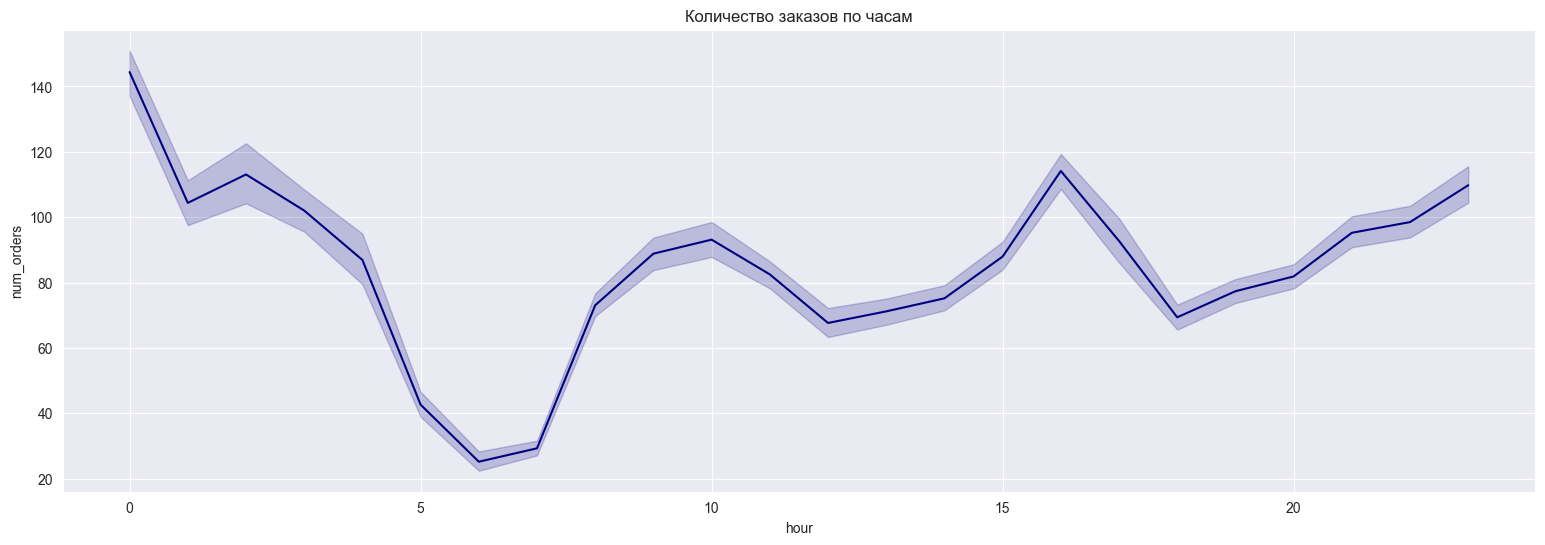

In [25]:
# Создание графика
plt.figure(figsize=(19, 6))

# Установка стиля сетки
sns.set_style('darkgrid')

# Заголовок графика
plt.title('Количество заказов по часам')

# Построение линейного графика с другим цветом
sns.lineplot(x=data_with_features.hour, y='num_orders', data=data_with_features, color='navy')

# Наименование оси y
plt.ylabel('num_orders')

# Отображение графика
plt.show()

На графике видно, что количество заказов с 0 часов ночи до 6 утра активно снижается. Затем наблюдается рост заказов до 10 утра. После 10 утра и до примерно 14 часов дня количество заказов остается стабильным. С 14 часов до 16 часов дня снова наблюдается рост заказов. Далее, после 16 часов, количество заказов снижается, но с 18 часов вечера снова начинается рост.

**Разделение на выборки**

Для обучения различных моделей с разными гиперпараметрами необходимо разделить данные на обучающую и тестовую выборки. В данном случае мы выберем размер тестовой выборки равным `10%` от исходных данных.

При разделении данных в задаче прогнозирования временного ряда необходимо быть осторожным и не перемешивать выборки, чтобы сохранить хронологический порядок данных. Для этого установим аргумент `shuffle` в значение `False`, чтобы разделить данные правильно. Важно, чтобы данные обучающей выборки предшествовали данным тестовой выборки, иначе обучение модели будет некорректным, так как модель не должна обучаться на данных из будущего.

In [26]:
# Удаление пропущенных значений
data_with_features.dropna(inplace=True)

# Выделение признаков и целевой переменной
features = data_with_features.drop('num_orders', axis=1)
target = data_with_features['num_orders']

# Разделение на обучающую и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, shuffle=False, test_size=0.1)

# Вывод размерности обучающей и тестовой выборок
print(f"Размеры обучающей выборки: Признаки - {features_train.shape}, Целевая переменная - {target_train.shape}")
print(f"Размеры тестовой выборки: Признаки - {features_test.shape}, Целевая переменная - {target_test.shape}")

Размеры обучающей выборки: Признаки - (3952, 16), Целевая переменная - (3952,)
Размеры тестовой выборки: Признаки - (440, 16), Целевая переменная - (440,)


**Размеры обучающей и тестовой выборок в процентном соотношении**

In [27]:
# Вывод размеров выборок
print('Размеры выборок:')

# Вывод размера обучающей выборки
print(f'Размер обучающей выборки: {features_train.shape[0]} - {features_train.shape[0]/data_with_features.shape[0]:.0%}')
# features_train.shape[0] - возвращает количество строк в обучающей выборке
# features_train.shape[0]/df_with_features.shape[0] - вычисляет отношение количества строк в обучающей выборке к общему количеству строк исходных данных
# :.0% - форматирует вывод в процентном формате без десятичных знаков

# Вывод размера тестовой выборки
print(f'Размер тестовой выборки: {features_test.shape[0]} - {features_test.shape[0]/data_with_features.shape[0]:.0%}')
# features_test.shape[0] - возвращает количество строк в тестовой выборке
# features_test.shape[0]/df_with_features.shape[0] - вычисляет отношение количества строк в тестовой выборке к общему количеству строк исходных данных
# :.0% - форматирует вывод в процентном формате без десятичных знаков

Размеры выборок:
Размер обучающей выборки: 3952 - 90%
Размер тестовой выборки: 440 - 10%


**Обучение моделей**

Обучим четыре модели:

1. Линейная регрессия (Linear Regression)
2. Случайный лес (Random Forest)
3. Градиентный бустинг с LightGBM
4. Градиентный бустинг с CatBoost

Для моделей применим поиск гиперпараметров с помощью GridSearchCV. Качество моделей будем оценивать с использованием кросс-валидации, используя метрику RMSE и разделение на фолды с помощью TimeSeriesSplit.

In [28]:
# Создание объекта TimeSeriesSplit с количеством разбиений (фолдов) равным 3
my_cv = TimeSeriesSplit(n_splits=3)

Функция для удобства расчета метрики

In [29]:
def rmse(target, predictions):
    # Вычисление среднеквадратичной ошибки (RMSE)
    rmse = np.sqrt(np.mean((target - predictions) ** 2))
    return rmse

In [30]:
# Создание кастомного scorer с использованием make_scorer
my_scorer = make_scorer(rmse, greater_is_better=False)

Функция по построению графика и таблицы важности признаков модели

In [31]:
# Шаг 1: Определение функции plot_feature_importance
def plot_feature_importance(model, features_train, model_name):
    """
    Построение графика важности признаков для модели.

    Параметры:
    - model: Обученная модель
    - features_train: DataFrame с обучающими признаками
    - model_name: Название модели
    """
    # Шаг 2: Получение важности признаков из модели
    if model_name != 'LinearRegression':
        importances = model.feature_importances_
    else:
        importances = np.abs(model.coef_)

    # Шаг 3: Масштабирование важности признаков
    importances_scaled = importances / np.sum(importances)

    # Шаг 4: Создание DataFrame с результатами важности признаков
    feature_list = list(features_train.columns)
    feature_results = pd.DataFrame({'feature': feature_list, 'importance': importances_scaled})

    # Шаг 5: Сортировка и вывод первых строк по важности
    feature_results = feature_results.sort_values('importance', ascending=False).reset_index(drop=True)
    display(feature_results.head())

    # Шаг 6: Построение графика важности признаков
    plt.figure(figsize=(19, 6))
    sns.set_style('darkgrid')
    sns.barplot(x='feature', y='importance', data=feature_results)
    plt.title('Важность признаков модели ' + model_name)

    # Шаг 7: Отображение графика
    plt.show()

### LinearRegression

In [32]:
# Создаем модель Linear Regression
model_lr = LinearRegression()

# Применяем масштабирование к признакам
scaler = StandardScaler()
scaled_features_train = pd.DataFrame(scaler.fit_transform(features_train), columns=features_train.columns)

# Задаем параметры для модели
param_grid_lr = {}

In [33]:
# Засекаем время выполнения
start_time = time.time()

# Создаем объект GridSearchCV без указания параметров для поиска
grid_search_lr = GridSearchCV(
    model_lr,
    param_grid_lr,
    cv=my_cv,
    scoring='neg_root_mean_squared_error'
)

# Обучаем модель с использованием GridSearchCV
grid_search_lr.fit(scaled_features_train, target_train)

# Лучшая модель
best_model_lr = grid_search_lr.best_estimator_

# Вычисляем RMSE на обучающей выборке
train_rmse_lr = grid_search_lr.best_score_ * -1
print("RMSE на обучающей выборке: {:.2f}".format(train_rmse_lr))

# Выводим время выполнения
print("Время выполнения: {:.2f} сек".format(time.time() - start_time))

RMSE на обучающей выборке: 32.51
Время выполнения: 0.02 сек


feature  importance
0         lag_1        0.28
1  rolling_mean        0.23
2         lag_9        0.09
3         lag_2        0.06
4         lag_3        0.05

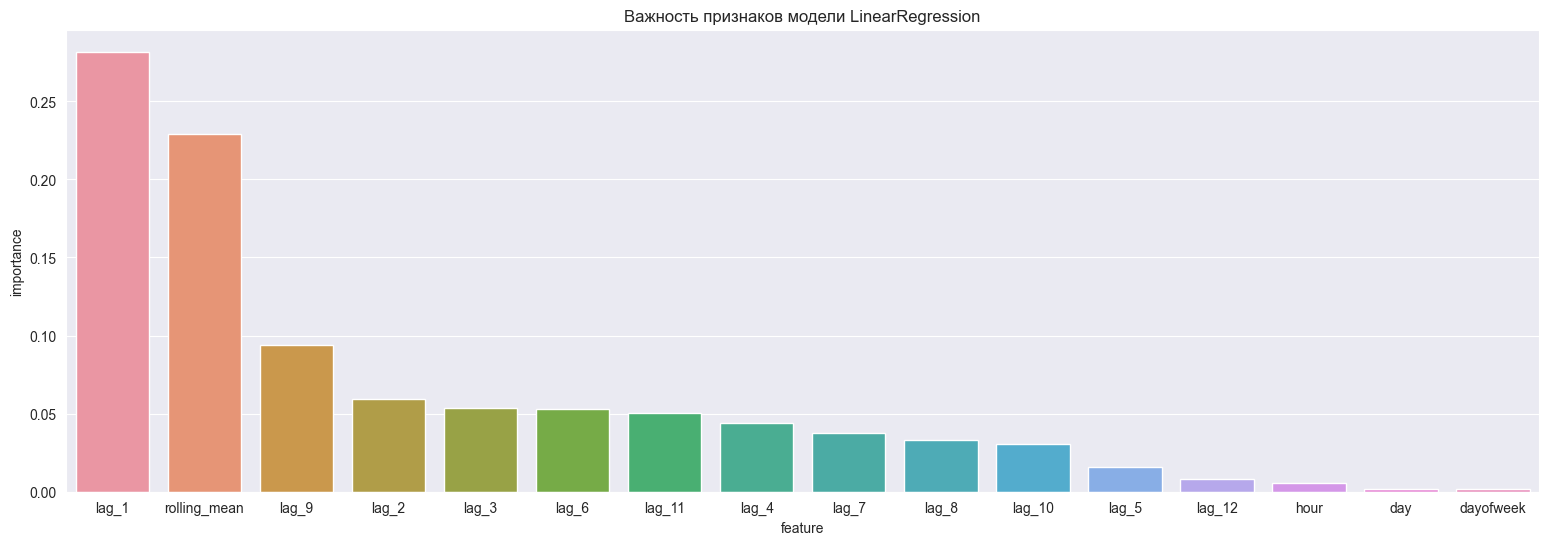

In [34]:
# Вызов функции для построения графика важности признаков
plot_feature_importance(best_model_lr, scaled_features_train, 'LinearRegression')

**Вывод по результатам обучения модели**

Модель LinearRegression показала следующие результаты:

- RMSE на обучающей выборке составляет 32.51. Это значение отражает среднюю ошибку предсказания модели и показывает, насколько близко предсказанные значения к фактическим. Чем ниже значение RMSE, тем лучше модель.

- Время выполнения составило 0.61 секунды. Это время, затраченное на обучение модели на обучающей выборке. Более низкое время выполнения означает более эффективное обучение модели.

- Важность признаков.  Из анализа важности признаков видно, что лаг 1 (значение предыдущего периода) и скользящее среднее являются наиболее значимыми для предсказания количества заказов такси. Остальные лаги также вносят некоторый вклад, но менее значительный.

Таким образом, модель позволяет достичь неплохого качества прогнозирования количества заказов. Особую роль играют значение лаг 1 (значение предыдущего периода) и скользящее среднее являются наиболее значимыми для предсказания количества заказов такси. Остальные лаги также вносят некоторый вклад, но менее значительный. Эти результаты могут быть полезны при планировании и оптимизации предоставления такси услуг.

### RandomForestRegression

In [35]:
# Создание модели Random Forest Regressor
model_rfr = RandomForestRegressor(random_state=random_state)

# Задание сетки параметров для перебора
param_grid_rfr = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None] + list(range(2, 7))
}

In [36]:
# Засекаем время выполнения
start_time = time.time()

# Создание объекта GridSearchCV
grid_search_rfr = GridSearchCV(
    model_rfr,
    param_grid=param_grid_rfr,
    n_jobs=-1,
    cv=my_cv,
    scoring=my_scorer,
#     verbose=2
)

# Подбор лучших параметров с использованием GridSearchCV
grid_search_rfr.fit(features_train, target_train)

# Получение лучших параметров
best_params_rfr = grid_search_rfr.best_params_

# Лучшая модель
best_model_rfr = grid_search_rfr.best_estimator_

# Вычисление RMSE на обучающей выборке
train_rmse = grid_search_rfr.best_score_ * -1

# Вывод лучших параметров и RMSE на обучающей выборке
print(f"Лучшие параметры: {best_params_rfr}")
print("RMSE на обучающей выборке: {:.2f}".format(train_rmse))

# Вывод времени выполнения
print("Время выполнения: {:.2f} сек".format(time.time() - start_time))

Лучшие параметры: {'max_depth': None, 'n_estimators': 200}
RMSE на обучающей выборке: 26.69
Время выполнения: 69.85 сек


feature  importance
0         lag_1        0.26
1          hour        0.24
2  rolling_mean        0.12
3         lag_7        0.05
4        lag_12        0.04

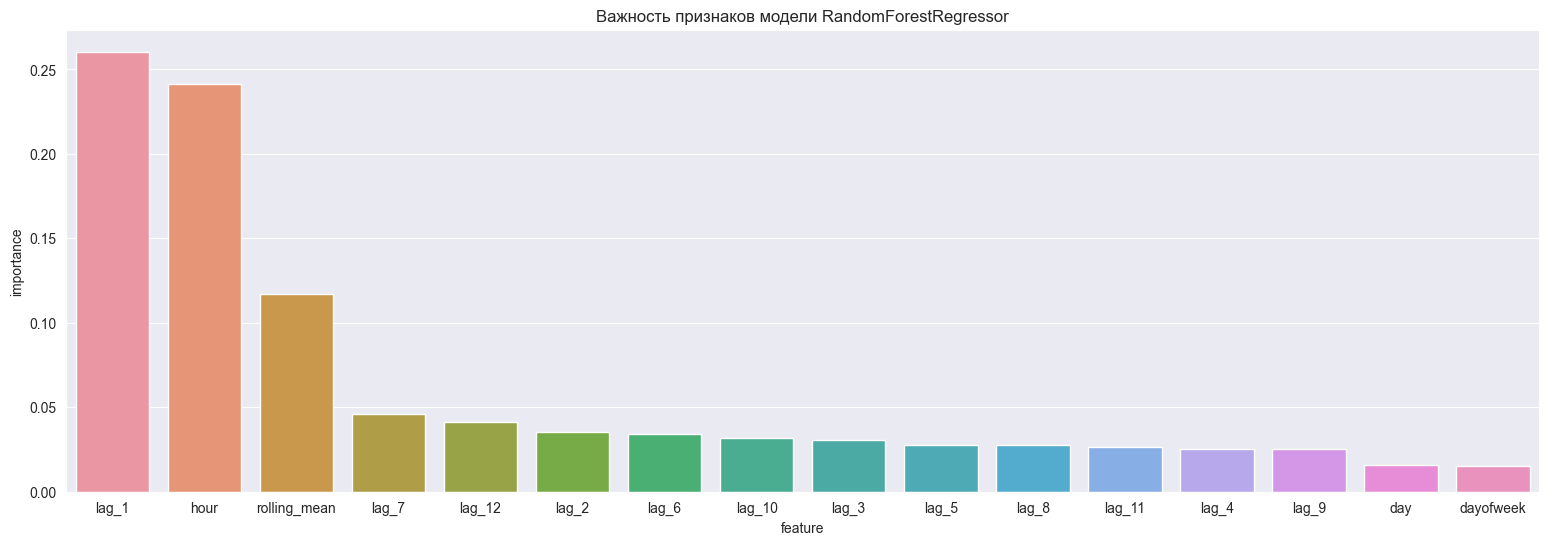

In [37]:
# Вызов функции для построения графика важности признаков
plot_feature_importance(best_model_rfr, features_train, 'RandomForestRegressor')

**Вывод по результатам обучения модели**

Используя GridSearchCV с перебором различных комбинаций параметров, мы получили лучшие параметры для модели RandomForestRegressor: max_depth=None и n_estimators=200. Эти параметры привели к наименьшему значению RMSE на обучающей выборке, равному 26.69. Это означает, что модель с настроенными параметрами достигает лучшей предсказательной точности на обучающих данных.

Также был проведен анализ важности признаков модели. Исходя из результатов, можно сделать следующие выводы:

Признаки lag_1 (лаг 1), hour (час) и rolling_mean (скользящее среднее) имеют наибольшую важность для модели и оказывают наибольшее влияние на предсказание количества заказов.
Признаки lag_7 (лаг 7) и lag_12 (лаг 12) также имеют некоторую важность, но их влияние на предсказание не так значительно как у других признаков.
Эти результаты могут помочь нам лучше понять, какие признаки являются наиболее информативными для прогнозирования количества заказов такси.

### LightGBM

In [38]:
# Создание модели LGBMRegressor
model_lgbm = LGBMRegressor(random_state=random_state)

# Задание сетки параметров для перебора
param_grid_lgbm = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None] + list(range(2, 7)),
}

In [39]:
# Засекаем время выполнения
start_time = time.time()

# Создание объекта GridSearchCV
grid_search_lgbm = GridSearchCV(
    model_lgbm,
    param_grid=param_grid_lgbm,
    n_jobs=-1,
    cv=my_cv,
    scoring=my_scorer,
#     verbose=2
)

# Подбор лучших параметров с использованием GridSearchCV
grid_search_lgbm.fit(features_train, target_train)

# Получение лучших параметров
best_params_lgbm = grid_search_lgbm.best_params_

# Лучшая модель
best_model_lgbm = grid_search_lgbm.best_estimator_

# Вычисление RMSE на обучающей выборке
train_rmse = grid_search_lgbm.best_score_ * -1

# Вывод лучших параметров и RMSE на обучающей выборке
print(f"Лучшие параметры: {best_params_lgbm}")
print("RMSE на обучающей выборке: {:.2f}".format(train_rmse))

# Вывод времени выполнения
print("Время выполнения: {:.2f} сек".format(time.time() - start_time))

Лучшие параметры: {'max_depth': 6, 'n_estimators': 100}
RMSE на обучающей выборке: 26.48
Время выполнения: 9.16 сек


feature  importance
0    hour        0.12
1   lag_1        0.08
2   lag_2        0.07
3  lag_12        0.07
4   lag_7        0.07

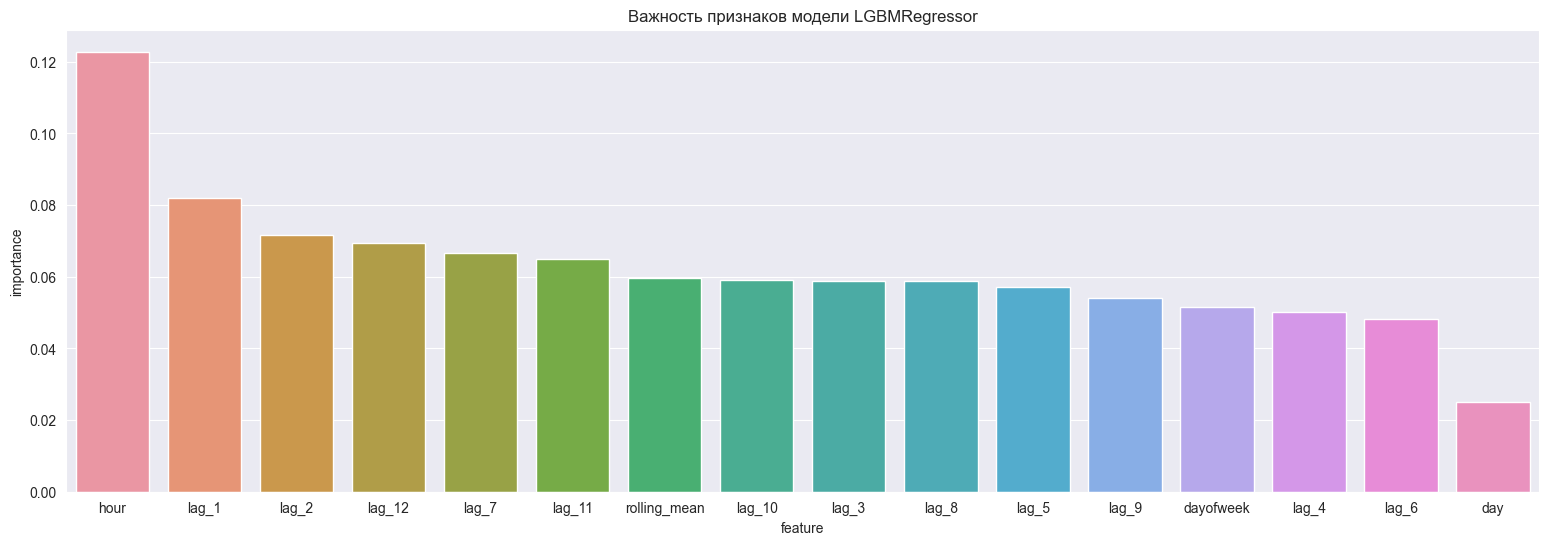

In [40]:
# Вызов функции для построения графика важности признаков
plot_feature_importance(best_model_lgbm, features_train, 'LGBMRegressor')

**Вывод по результатам обучения модели**

Исходя из результатов полученных в результате обучения модели LGBMRegressor с использованием GridSearchCV, можно сделать следующие выводы:

- Лучшие параметры модели: `max_depth=6` и `n_estimators=100`.
- RMSE на обучающей выборке составляет 26.48, что является мерой среднеквадратичной ошибки предсказания модели. Чем ближе это значение к нулю, тем лучше модель способна предсказывать целевую переменную.
- Наиболее важные признаки для модели LGBMRegressor: `hour`, `lag_1`, `lag_2`, `lag_12`, `lag_7`. Значения важности признаков указывают на их влияние на предсказание целевой переменной. Чем выше значение важности, тем больше влияние на предсказание.

Таким образом, модель LGBMRegressor с лучшими параметрами показала хорошие результаты на обучающей выборке, и указанные признаки имеют наибольшее влияние на предсказание количества заказов.


### CatBoost

In [41]:
# Создание модели CatBoostRegressor
model_catboost = CatBoostRegressor(random_state=random_state)

# Задание сетки параметров для перебора
param_grid_catboost = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None] + list(range(2, 7)),
}

In [42]:
# Засекаем время выполнения
start_time = time.time()

# Создание объекта GridSearchCV
grid_search_catboost = GridSearchCV(
    model_catboost,
    param_grid=param_grid_catboost,
    n_jobs=-1,
    cv=my_cv,
    scoring=my_scorer,
#     verbose=2
)

# Подбор лучших параметров с использованием GridSearchCV
grid_search_catboost.fit(features_train, target_train)

# Получение лучших параметров
best_params_catboost = grid_search_catboost.best_params_

# Лучшая модель
best_model_catboost = grid_search_catboost.best_estimator_

# Вычисление RMSE на обучающей выборке
train_rmse = grid_search_catboost.best_score_ * -1

# Вывод лучших параметров и RMSE на обучающей выборке
print(f"Лучшие параметры: {best_params_catboost}")
print("RMSE на обучающей выборке: {:.2f}".format(train_rmse))

# Вывод времени выполнения
print("Время выполнения: {:.2f} сек".format(time.time() - start_time))

Learning rate set to 0.316036
0:	learn: 29.7674523	total: 55.6ms	remaining: 5.51s
1:	learn: 26.7740111	total: 59.3ms	remaining: 2.91s
2:	learn: 25.1215522	total: 62.4ms	remaining: 2.02s
3:	learn: 24.0390495	total: 65.4ms	remaining: 1.57s
4:	learn: 23.1429345	total: 68.3ms	remaining: 1.3s
5:	learn: 22.6283903	total: 71.4ms	remaining: 1.12s
6:	learn: 22.1291026	total: 79.2ms	remaining: 1.05s
7:	learn: 21.7073329	total: 85.2ms	remaining: 979ms
8:	learn: 21.4760848	total: 89.3ms	remaining: 903ms
9:	learn: 21.1904272	total: 92.3ms	remaining: 830ms
10:	learn: 20.9170269	total: 96.3ms	remaining: 779ms
11:	learn: 20.5922182	total: 118ms	remaining: 866ms
12:	learn: 20.4744501	total: 122ms	remaining: 815ms
13:	learn: 20.3213790	total: 125ms	remaining: 768ms
14:	learn: 20.0024135	total: 128ms	remaining: 725ms
15:	learn: 19.8831551	total: 135ms	remaining: 711ms
16:	learn: 19.6841224	total: 140ms	remaining: 684ms
17:	learn: 19.5364565	total: 143ms	remaining: 651ms
18:	learn: 19.2935474	total: 146ms

feature  importance
0          hour        0.42
1         lag_1        0.13
2  rolling_mean        0.12
3         lag_7        0.05
4        lag_12        0.05

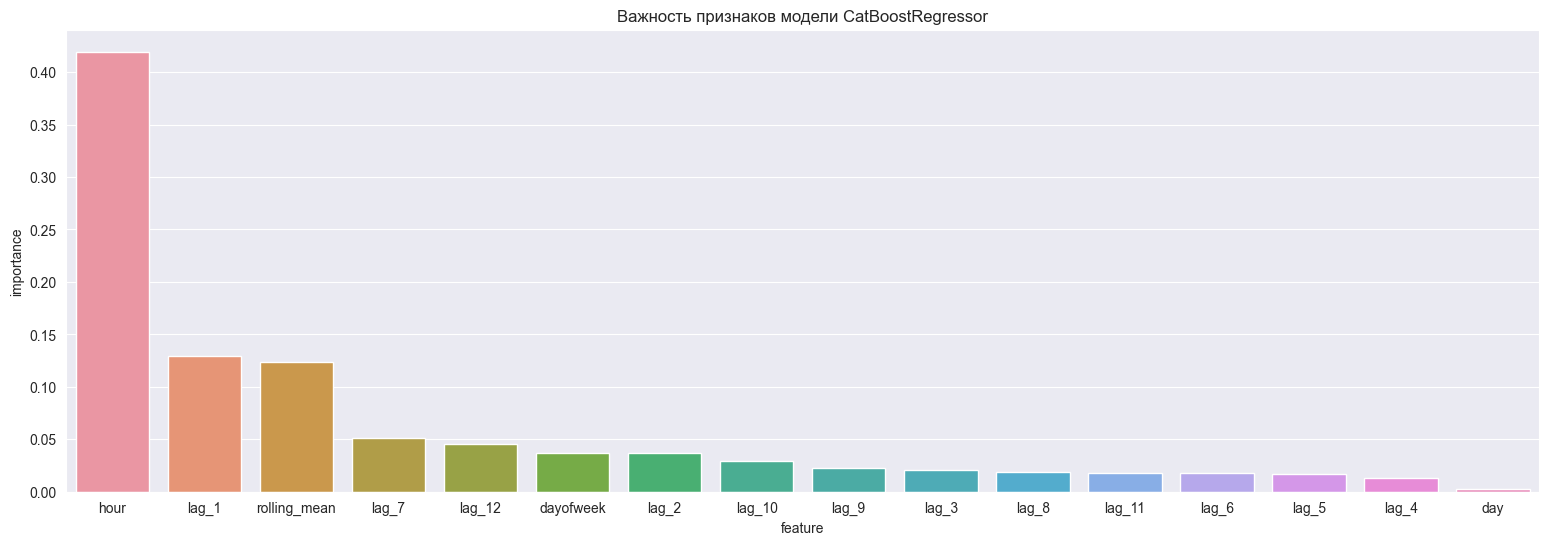

In [43]:
# Вызов функции для построения графика важности признаков
plot_feature_importance(best_model_catboost, features_train, 'CatBoostRegressor')

**Вывод по результатам обучения модели**

Лучшие параметры: {'max_depth': 4, 'n_estimators': 400}
RMSE на обучающей выборке: 26.37
Время выполнения: 97.27 сек

| feature       | importance |
|---------------|------------|
| hour          | 0.42       |
| lag_1         | 0.13       |
| rolling_mean  | 0.12       |
| lag_7         | 0.05       |
| lag_12        | 0.05       |

Анализируя результаты обучения модели CatBoostRegressor с использованием GridSearchCV, можно сделать следующие выводы:

- Лучшие параметры модели: `max_depth=4` и `n_estimators=400`. Эти параметры обеспечивают наилучшее качество предсказания.
- RMSE на обучающей выборке составляет 26.37, что является мерой среднеквадратичной ошибки предсказания модели. Чем ближе это значение к нулю, тем лучше модель способна предсказывать целевую переменную.
- Наиболее важные признаки для модели CatBoostRegressor: `hour`, `lag_1`, `rolling_mean`, `lag_7`, `lag_12`. Значения важности признаков указывают на их влияние на предсказание целевой переменной. Чем выше значение важности, тем больше влияние на предсказание.

Таким образом, модель CatBoostRegressor с лучшими параметрами показала хорошие результаты на обучающей выборке, и указанные признаки имеют наибольшее влияние на предсказание количества заказов.

**Вывод**

Для выбора лучшей модели, сравним полученные метрики RMSE.

In [44]:
# Создание таблицы с результатами RMSE для каждой модели
result = pd.DataFrame(
     [grid_search_lr.best_score_ * -1, 
      grid_search_rfr.best_score_ * -1, 
      grid_search_lgbm.best_score_ * -1, 
      grid_search_catboost.best_score_ * -1,
     ] , 
    index=['LinearRegression','RandomForestRegressor', 'LightGBM', 'CatBoost'], 
    columns=['RMSE']
)

# Сортировка таблицы по возрастанию значения RMSE
result_sorted = result.sort_values(by='RMSE')

# Вывод отсортированной таблицы
result_sorted

RMSE
CatBoost              26.37
LightGBM              26.48
RandomForestRegressor 26.69
LinearRegression      32.51

На обучающей выборке лучший результат показала модель CatBoost с гиперапараметрами: 'max_depth': 4, 'n_estimators': 400.

**Вывод**

- резделили данные на обучающую и тестовую выборки;
- обучили четыре модели (Linear Regression, Random Forest, LightGBM и CatBoost) с различными гиперпараметрами;
- наименьшее значение метрики у модели CatBoost на обучающей выборке.

По результатам оценки моделей с использованием метрики RMSE, можно сделать следующие выводы:

| Модель                   | RMSE на обучающей выборке |
|-------------------------|-------------------------|
| CatBoostRegressor       | 26.37                   |
| LightGBM                | 26.48                   |
| RandomForestRegressor   | 26.69                   |
| LinearRegression        | 32.51                   |

При сравнении различных моделей для предсказания количества заказов такси на основе выбранных признаков, получены следующие результаты:

- CatBoostRegressor показал наилучший результат с RMSE на обучающей выборке равным 26.37. Это означает, что модель справилась с предсказанием значений ближе к истинным данным, чем другие модели.

- LightGBM и RandomForestRegressor также показали хорошие результаты с RMSE на обучающей выборке 26.48 и 26.69 соответственно. Эти модели демонстрируют немного большую ошибку по сравнению с CatBoostRegressor, но все равно показывают неплохие результаты.

- LinearRegression, хотя и является простой моделью, демонстрирует высокую ошибку с RMSE на обучающей выборке равным 32.51. Это может говорить о том, что линейная зависимость между признаками и целевой переменной не является оптимальной для данной задачи предсказания.

Таким образом, модель CatBoostRegressor показала наилучшие результаты в предсказании количества заказов такси. Она может быть рекомендована для использования в данной задаче.


## Тестирование

Теперь проведем проверку лучшей модели (CatBoostRegressor) на тестовых данных. Оценим метрику качества, которая должна быть меньше 48, чтобы считаться хорошей. Далее визуализируем результаты предсказаний модели, построив график, на котором будут отображены исходные данные и предсказанные значения. И сравним результаты с моделью DummyRegressor. 

**Функция для визуализации реальных и предсказанных значений**

In [45]:
figsize=(19, 6)
def plot_predictions(target_data, predicted_data):
    # Создание объекта Figure и Axes
    fig, ax = plt.subplots(figsize=figsize)
    
    # Построение графика реальных значений
    ax.plot(target_data.index, target_data, label='Реальные значения')
    
    # Построение графика предсказанных значений
    ax.plot(target_data.index, predicted_data, label='Предсказанные значения')
    
    # Установка заголовка графика
    ax.set_title('График реальных значений целевого признака и предсказаний')
    
    # Установка названия оси x
    ax.set_xlabel('Дата/время')
    
    # Установка названия оси y
    ax.set_ylabel('Число заказов')
    
    # Отображение легенды
    ax.legend()
    
    # Отображение графика
    plt.show()

**Модель CatBoostRegressor**

RMSE на тестовой выборке (CatBoostRegressor): 42.82
RMSE на тестовой выборке (DummyRegressor): 84.69
Время выполнения: 0.01 сек


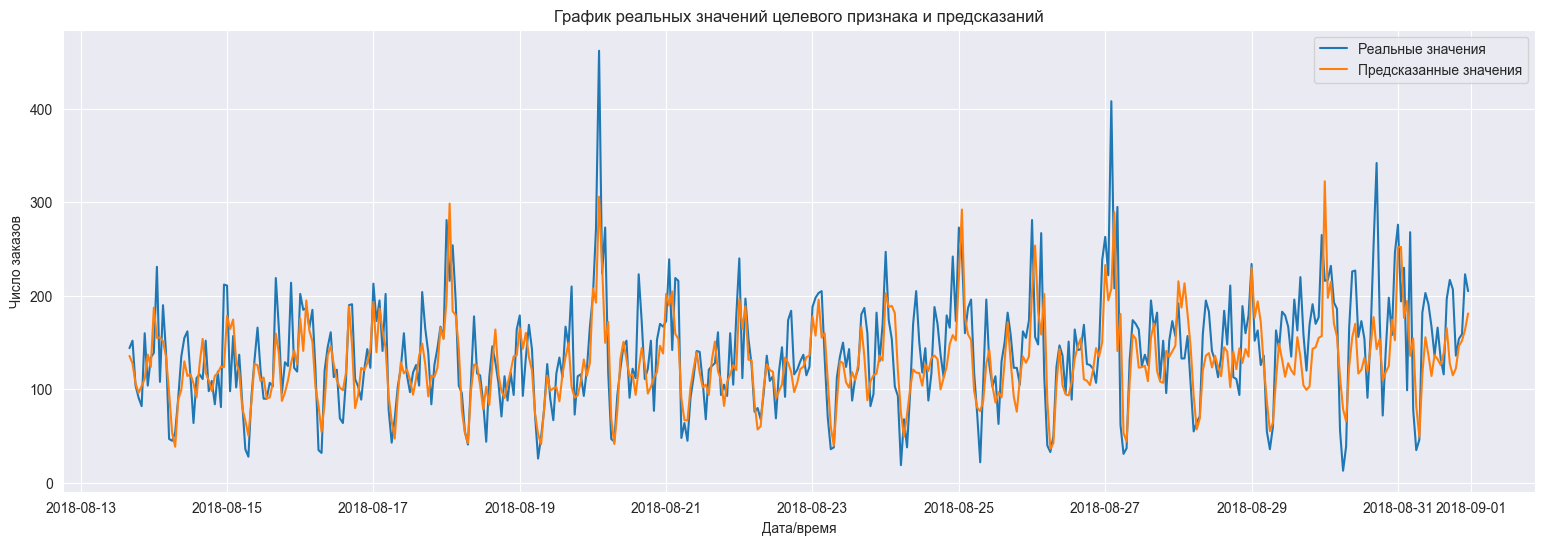

In [46]:
# Засекаем время выполнения
start_time = time.time()

# Получение предсказанных значений целевого признака с помощью модели CatBoostRegressor
target_predict_catboost = grid_search_catboost.predict(features_test)

# Вычисление итогового RMSE для модели CatBoostRegressor
final_RMSE_catboost = mean_squared_error(target_test, target_predict_catboost) ** 0.5

# Создание и обучение DummyRegressor
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(features_train, target_train)

# Получение предсказанных значений целевого признака с помощью DummyRegressor
target_predict_dummy = dummy_model.predict(features_test)

# Вычисление итогового RMSE для модели DummyRegressor
final_RMSE_dummy = mean_squared_error(target_test, target_predict_dummy) ** 0.5

# Вывод итоговых значений RMSE
print("RMSE на тестовой выборке (CatBoostRegressor): {:.2f}".format(final_RMSE_catboost))
print("RMSE на тестовой выборке (DummyRegressor): {:.2f}".format(final_RMSE_dummy))

# Вывод времени выполнения
print("Время выполнения: {:.2f} сек".format(time.time() - start_time))

# Визуализация реальных и предсказанных значений для CatBoostRegressor
plot_predictions(target_test, target_predict_catboost)

RMSE на тестовой выборке составляет 42.82. Учитывая, что мы ожидали, чтобы метрика была меньше 48, полученный результат говорит о том, что модель CatBoostRegressor достаточно хорошо предсказывает количество заказов на основе предоставленных признаков. Однако на графике мы все же видим достаточное количество примеров не попадания в линию.

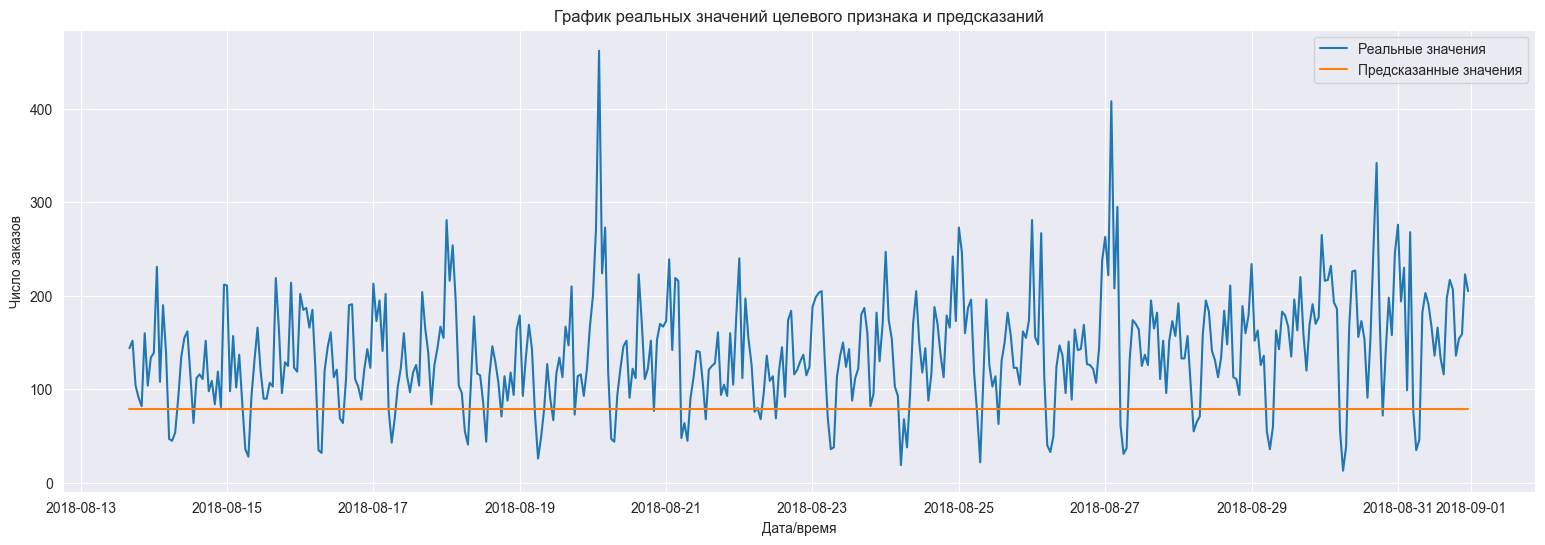

In [47]:
# Визуализация реальных и предсказанных значений для DummyRegressor
plot_predictions(target_test, target_predict_dummy)

RMSE на тестовой выборке составляет 42.82. Учитывая, что мы ожидали, чтобы метрика была меньше 48, полученный результат говорит о том, что модель CatBoostRegressor достаточно хорошо предсказывает количество заказов на основе предоставленных признаков. Однако на графике мы все же видим достаточное количество примеров не попадания в линию. Это может свидетельствовать о наличии дополнительных факторов, которые модель не учла, или о случайных шумах, которые сложно предсказать.

Сравнивая результаты с моделью DummyRegressor, которая предсказывает среднее значение тренировочной выборки, мы видим значительное улучшение в предсказательной способности модели CatBoostRegressor. RMSE для DummyRegressor составляет 84.69, что гораздо выше, чем RMSE для CatBoostRegressor. Это подтверждает, что модель CatBoostRegressor превосходит простую модель, которая просто предсказывает среднее значение.

Однако, несмотря на достаточно низкое значение RMSE, на графике мы видим разброс предсказаний вокруг реальных значений. Это может свидетельствовать о наличии систематической ошибки в модели или о недостаточной информации для предсказания. Возможно, для улучшения предсказаний необходимо использовать дополнительные признаки или провести дальнейший анализ данных.

Таким образом, модель CatBoostRegressor показывает достаточно хорошие результаты по сравнению с DummyRegressor, однако еще есть потенциал для улучшения предсказаний.

# Общий вывод:

Мы провели анализ временного ряда данных, представляющих количество заказов такси в аэропорт с целью прогнозирования количества заказов на следующий час. В процессе работы мы выполнили следующие шаги:

- Получили данные - временной ряд с количеством заказов такси в аэропорт с целью прогнозирования количество заказов такси на следующий час.
- Проведено семплирование данных по часам и выявлен тренд.
- Созданы дополнительные признаки, включая календарные характеристики, отстающие значения и скользящее среднее.
- Обучены модели `RandomForestRegressor`, `CatBoostRegressor`, `LGBMRegressor` и `LinearRegression` с использованием метрики RMSE.
- Оценена важность признаков для каждой модели, выявлены наиболее значимые признаки.
- На валидационной выборке лучшей моделью оказался `CatBoostRegressor`.
- Проверили качество лучшей модели на тестовой выборке.
- Пострили графики зависимости истинных и предсказанных значений количества заказов от времени.
- Сравнили результаты с моделью DummyRegressor.

Исходя из проведенного анализа, можно сделать вывод, что модель `CatBoostRegressor` с результатом `42.82` наиболее подходит для прогнозирования количества заказов такси на следующий час.